# **PROJET ML01 : DIAGNOSTIQUE D'UNE MALADIE CARDIAQUE**  

**GROUPE 21 : PORTELA Juana, MAZZANTE Lorenzo, SCORZA Martin, FIORITI Federico**


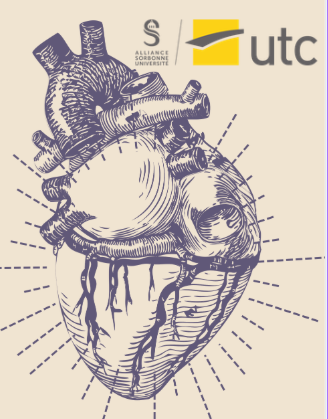






# Introduction
Dans ce notebook, nous présentons un projet de détection de maladie cardiovasculaire à l’aide de méthodes de Machine Learning. À partir d’une base de données contenant des variables cliniques et liées au mode de vie (âge, pression artérielle, cholestérol, glycémie, habitudes, activité physique, etc.), nous cherchons à entraîner et comparer différents modèles afin de prédire la présence d’une maladie cardiovasculaire.

# Organisation du travail

Le notebook est divisé en trois parties :
## I) Déclaration des fonctions pour l'analyse des performances

Nous déclarerons les fonctions à utiliser dans la section III pour evaluer les différents paramètres statistiques des modèles utilisés.

## II) Nettoyage et préparation des données

Nous réaliserons un nettoyage de la base de données, car elle contient des valeurs non cohérentes avec la réalité (par exemple des outliers ou des enregistrements impossibles) susceptibles de dégrader les prédictions, d’introduire des biais, ou encore de ralentir l’entraînement.

## III) Validation croisée et évaluation des modèles

Nous déclarerons les fonctions qui appliquent les modèles et puis nous appliquerons une validation croisée afin d’évaluer tous les méthodes de manière cohérente. Nous calculerons des métriques statistiques et nous mesurerons également l’impact environnemental, en estimant les émissions de carbone associées à l’entraînement/évaluation des modèles.

## IV) Interprétation et conclusion

Enfin, nous proposerons une interprétation des résultats, en comparant les forces et les limites des modèles utilisés (performance, interprétabilité, empreinte carbone, etc.).
Nous terminerons par une opinion argumentée sur la solution la plus adaptée, ainsi qu’une conclusion personnelle sur les apprentissages et les apports du projet.

In [ ]:
# Cette commande installe la bibliothèque "codecarbon"
# CodeCarbon sert à mesurer l'empreinte carbone de l'exécution de ton code
# Elle provient de PyPI et s'installe via pip dans ton environnement Python
!pip install codecarbon

In [ ]:
# On importe la bibliothèque pandas pour manipuler des tableaux de données (DataFrame)
import pandas as pd

# On importe numpy pour effectuer des calculs numériques et manipuler des tableaux
import numpy as np

# On importe matplotlib pour tracer des graphiques et visualiser les données
import matplotlib.pyplot as plt

# On importe seaborn pour créer des visualisations plus stylisées et faciles à interpréter
import seaborn as sns

# On importe EmissionsTracker pour mesurer l’empreinte carbone générée par l’exécution du code
from codecarbon import EmissionsTracker

from matplotlib.colors import LinearSegmentedColormap

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


# PARTIE I : Déclaration de fonctions pour l'analyse des performances

On va definir plusieurs critères d’évaluation pour analyser les performances des classifieurs

In [ ]:
# On définit une fonction qui calcule le risque moyen (risque global)
# YR     : étiquettes réelles (vecteur)
# Yhat   : étiquettes prédites par le classifieur
# Y_set  : ensemble des classes possibles (par exemple [0, 1])
# L      : matrice de perte (loss matrix)
def compute_average_risk(YR, Yhat, Y_set, L):

    # K : nombre de classes différentes
    K = len(Y_set)
    # n : nombre total d'observations
    n = len(YR)

    # On calcule le risque pour chaque classe (vecteur de taille K)
    R = compute_risk_per_class(YR, Yhat, Y_set, L)

    # On initialise le vecteur des proportions de chaque classe π (pi)
    pi = np.zeros(K)
    # Pour chaque classe k dans Y_set
    for idx_k in range(K):
        k = Y_set[idx_k]
        # π_k = proportion d’exemples dont la vraie étiquette est k
        pi[idx_k] = np.sum(YR == k) / n

    # On calcule le risque moyen r comme produit scalaire :
    # r = somme_k ( π_k * R_k )
    r = np.dot(pi, R)

    # On renvoie le risque moyen
    return r

In [ ]:
# On définit une fonction qui calcule l’accuracy (taux de bonnes prédictions)
def compute_accuracy(YR, Yhat):

    # n : nombre total d’observations
    n = len(YR)

    # On calcule la proportion de prédictions correctes
    Acc = np.sum(YR == Yhat) / n

    # On renvoie l’accuracy
    return Acc

In [ ]:
# On définit une fonction qui calcule l’accuracy (taux de bonnes prédictions)
# séparément pour chaque classe
def compute_accuracy_per_class(YR, Yhat, Y_set):

    # K : nombre de classes
    K = len(Y_set)

    # On initialise un vecteur pour stocker l’accuracy de chaque classe
    Acc_per_class = np.zeros(K)

    # Pour chaque classe k dans Y_set
    for idx_k in range(K):
        k = Y_set[idx_k]

        # n_k : nombre d’exemples appartenant à la classe k
        n_k = np.sum(YR == k)

        # Ik : indices des observations pour lesquelles la vraie classe est k
        Ik = np.where(YR == k)[0]

        # Accuracy pour la classe k :
        # proportion de prédictions correctes parmi les exemples de classe k
        Acc_per_class[idx_k] = np.sum(Yhat[Ik] == k) / n_k

    # On renvoie le vecteur des accuracies par classe
    return Acc_per_class

In [ ]:
# On définit une fonction qui calcule la matrice de confusion normalisée par classe
def compute_confusion_matrix(YR, Yhat, Y_set):

    # K : nombre de classes
    K = len(Y_set)

    # On initialise une matrice K x K remplie de zéros
    # confmat[k, l] contiendra la proportion d’exemples de vraie classe k
    # qui ont été prédits comme appartenant à la classe l
    confmat = np.zeros((K, K))

    # Pour chaque classe réelle k
    for idx_k in range(K):
        k = Y_set[idx_k]

        # nk : nombre d’exemples appartenant réellement à la classe k
        nk = np.sum(YR == k)

        # Ik : indices des observations dont la vraie étiquette est k
        Ik = np.where(YR == k)[0]

        # Pour chaque classe prédite l
        for idx_l in range(K):
            l = Y_set[idx_l]

            # confmat[k, l] : proportion d'exemples de vraie classe k
            # prédits comme étant de classe l
            confmat[idx_k, idx_l] = np.sum(Yhat[Ik] == l) / nk

    # On renvoie la matrice de confusion
    return confmat

In [ ]:
# On définit une fonction qui calcule le risque pour chaque classe
# L     : matrice de perte (loss matrix)
def compute_risk_per_class(YR, Yhat, Y_set, L):

    # K : nombre de classes
    K = len(Y_set)

    # On initialise un vecteur R qui contiendra le risque pour chaque classe
    R = np.zeros(K)

    # On calcule la matrice de confusion normalisée par classe
    confmat = compute_confusion_matrix(YR, Yhat, Y_set)

    # Pour chaque classe k
    for idx_k in range(K):
        # Le risque de la classe k est donné par le produit scalaire
        # entre la ligne k de la matrice de perte L
        # et la ligne k de la matrice de confusion confmat
        R[idx_k] = np.dot(L[idx_k, :], confmat[idx_k, :])

    # On renvoie le vecteur des risques par classe
    return R

# PARTIE II : Nettoyage et préparation de données

In [ ]:
# On charge le fichier 'dataset.csv' et on le lit sous forme de DataFrame pandas
# Cela permet d'utiliser le jeu de données pour l'analyse et l'entraînement des modèles
data = pd.read_csv('dataset.csv')

In [ ]:
# On affiche les cinq premières lignes du DataFrame
# Cela permet d’avoir un aperçu rapide de la structure et du contenu des données
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110.0,80.0,1,1,0,0,1,0
1,1,20228,1,156,85.0,140.0,90.0,3,1,0,0,1,1
2,2,18857,1,165,64.0,130.0,70.0,3,1,0,0,0,1
3,3,17623,2,169,82.0,150.0,100.0,1,1,0,0,1,1
4,4,17474,1,156,56.0,100.0,60.0,1,1,0,0,0,0


In [ ]:
# On affiche la taille du DataFrame sous la forme (nombre_de_lignes, nombre_de_colonnes)
# Cela permet de connaître la dimension exacte du jeu de données
data.shape

(70000, 13)

In [ ]:
# On affiche des informations détaillées sur le DataFrame :
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  float64
 6   ap_lo        70000 non-null  float64
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 6.9 MB


In [ ]:
# On supprime la colonne 'id' du DataFrame
# car elle ne contient aucune information utile pour l’analyse ou l’apprentissage du modèle
data = data.drop(columns=['id'])

# On convertit l'âge exprimé en jours en âge en années :
# on divise par 365 (on laisse les decimales pour les différences entre une personne
# qui vient d'avoir son anniversaire et une autre qui va l'avoir bientôt)
data['age'] = (data['age'] / 365).astype(float)


In [ ]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,2,168,62.0,110.0,80.0,1,1,0,0,1,0
1,55.419178,1,156,85.0,140.0,90.0,3,1,0,0,1,1
2,51.663014,1,165,64.0,130.0,70.0,3,1,0,0,0,1
3,48.282192,2,169,82.0,150.0,100.0,1,1,0,0,1,1
4,47.873973,1,156,56.0,100.0,60.0,1,1,0,0,0,0


In [ ]:
# On affiche un résumé statistique des variables numériques :
# moyenne, écart-type, min, max, quartiles, etc.
# Cela permet d’avoir une première analyse descriptive du jeu de données
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.339358,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.759594,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,29.583562,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.394521,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.980822,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.430137,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.967123,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# On applique des seuils sur certaines variables
# afin d’éliminer les observations qui n’ont pas de valeurs cohérentes :
# - poids (weight) au moins 30 kg
# - taille (height) au moins 70 cm
# - pression systolique (ap_hi) entre 0 et 300
# - pression diastolique (ap_lo) entre 0 et 300
data = data[
    (data['weight'] >= 30) &
    (data['height'] >= 70) &
    (data['ap_hi'] <= 300) &
    (data['ap_lo'] <= 300) &
    (data['ap_hi'] >= 0) &
    (data['ap_lo'] >= 0)
]

In [ ]:
YR = data['cardio']
X = data.drop(columns=['cardio'])

In [ ]:
# On définit une fonction pour tracer un nuage de points 2D en colorant selon une étiquette (label)
# df        : DataFrame contenant les données
# x_col     : nom de la colonne utilisée pour l’axe des x
# y_col     : nom de la colonne utilisée pour l’axe des y
# label_col : nom de la colonne contenant les étiquettes (par défaut 'cardio')
def plot_2d_by_label(df, x_col, y_col, label_col='cardio'):

    # On récupère l’ensemble des valeurs uniques de l’étiquette (ex : 0 et 1),
    # puis on les trie pour avoir un ordre cohérent
    labels = tuple(sorted(df[label_col].unique()))

    # On crée un masque pour les lignes ayant la première valeur de label
    mask_a = df[label_col] == labels[0]
    # On crée un masque pour les lignes ayant la deuxième valeur de label
    mask_b = df[label_col] == labels[1]

    # On crée une figure et un système d’axes avec une taille spécifique
    fig, ax = plt.subplots(figsize=(7.5, 7))

    # On trace les points correspondant au premier label
    # - marker='*' : forme d’étoile
    # - s=150      : taille des marqueurs
    # - color      : couleur du nuage de points
    ax.scatter(
        df.loc[mask_a, x_col],
        df.loc[mask_a, y_col],
        marker='*',
        s=150,
        label=f'{label_col} = {labels[0]}',
        color='skyblue'
    )

    # On trace les points correspondant au deuxième label
    # - marker='o' : cercles
    # - alpha=0.8  : légère transparence
    ax.scatter(
        df.loc[mask_b, x_col],
        df.loc[mask_b, y_col],
        marker='o',
        s=70,
        label=f'{label_col} = {labels[1]}',
        color='lightcoral',
        alpha=0.8
    )

    # On ajoute les noms des axes x et y avec une taille de police plus grande
    ax.set_xlabel(x_col, fontsize=16)
    ax.set_ylabel(y_col, fontsize=16)

    # On affiche la légende pour distinguer les deux groupes de labels
    ax.legend(fontsize=12)

    # On active la grille pour faciliter la lecture du graphique
    ax.grid(True)

    # On affiche le graphique à l’écran
    plt.show()


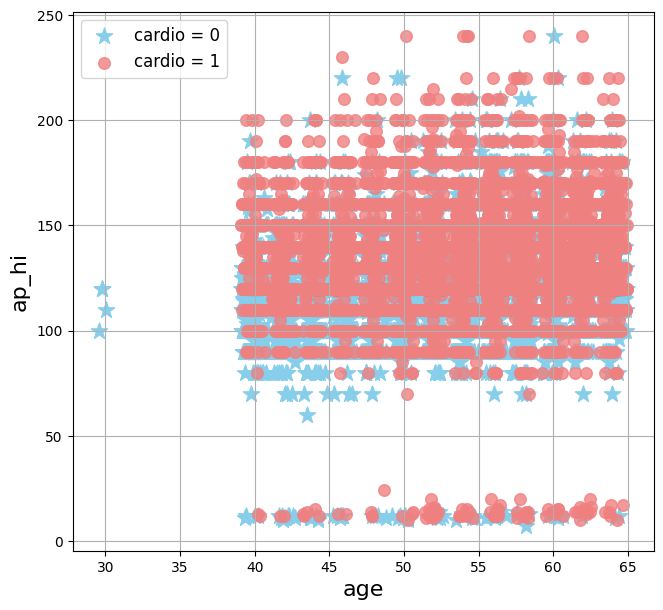

In [ ]:
plot_2d_by_label(data, 'age', 'ap_hi')

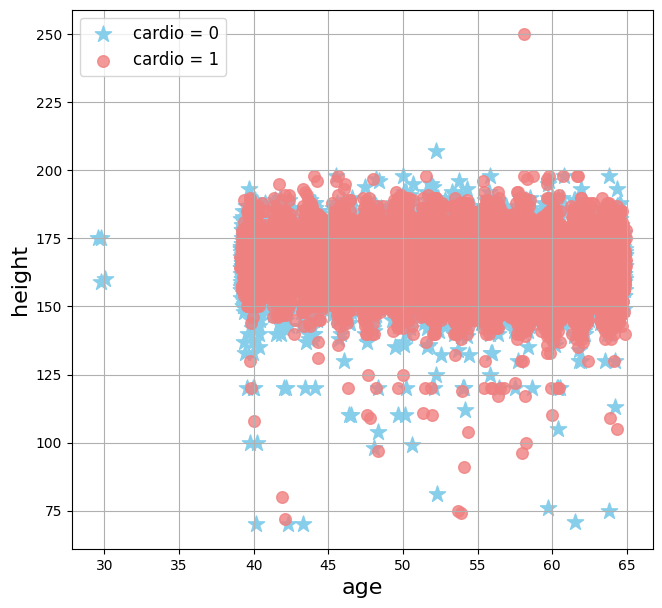

In [ ]:
plot_2d_by_label(data, 'age', 'height')

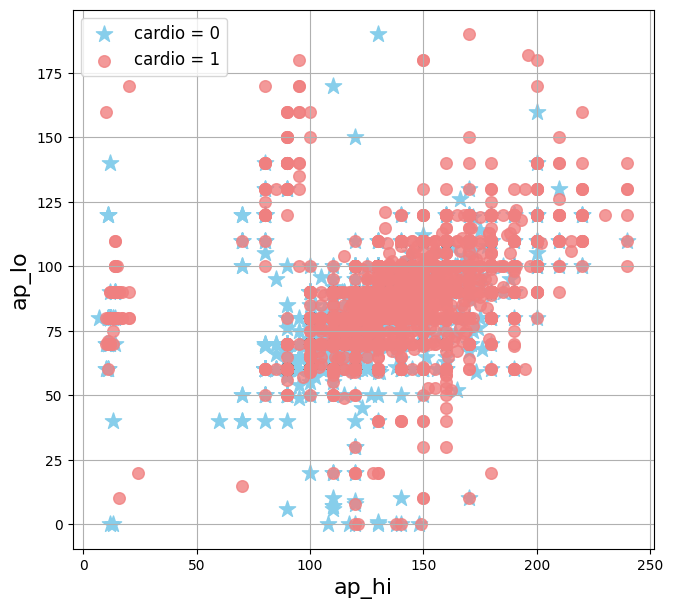

In [ ]:
plot_2d_by_label(data, 'ap_hi', 'ap_lo')

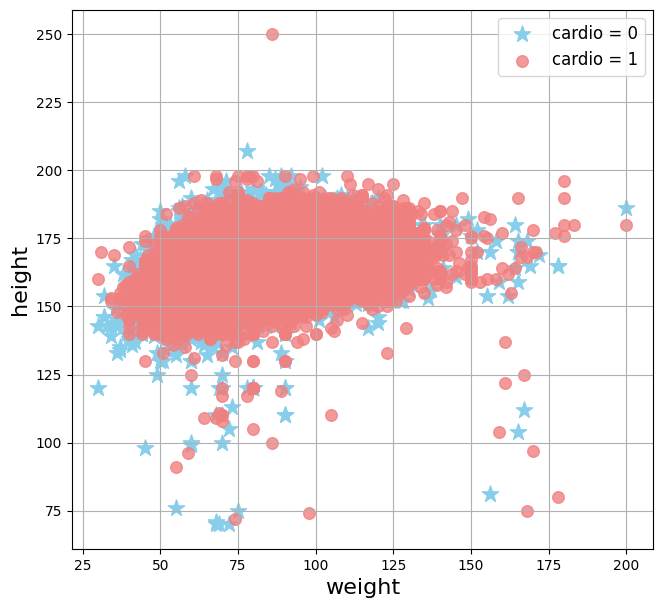

In [ ]:
plot_2d_by_label(data, 'weight', 'height')

In [ ]:
# On définit une fonction qui crée un graphique en barres groupées
# entre une variable catégorielle et la variable cible (par défaut 'cardio')
def plot_bar_by_label(data, variable, objectif='cardio'):

    # On définit la taille de la figure
    plt.figure(figsize=(8, 4))

    # On utilise countplot pour compter le nombre d'observations
    # pour chaque catégorie de 'variable', séparées par la variable cible 'objectif'
    sns.countplot(
        data=data,
        x=variable,
        hue=objectif,
        palette=['skyblue', 'lightcoral']  # couleurs pour les deux classes
    )

    # On ajoute un titre décrivant la distribution de la maladie par rapport à la variable
    plt.title(f'Distribution of disease by {variable}')

    # On nomme l’axe des x avec le nom de la variable, en capitalisant la première lettre
    plt.xlabel(variable.capitalize())

    # On nomme l’axe des y comme le nombre de patients
    plt.ylabel('Quantity of patients')

    # On ajoute une légende pour distinguer les deux classes de la variable cible
    plt.legend(title=objectif, labels=['0', '1'])

    # On ajoute une grille légère pour faciliter la lecture
    plt.grid(alpha=0.3)

    # On affiche le graphique
    plt.show()


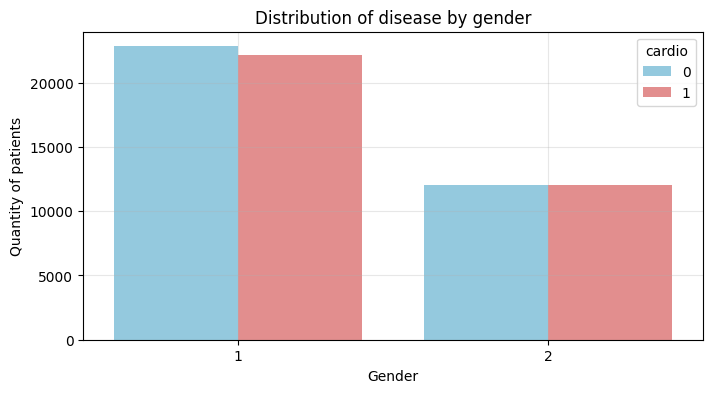

In [ ]:
plot_bar_by_label(data, 'gender')

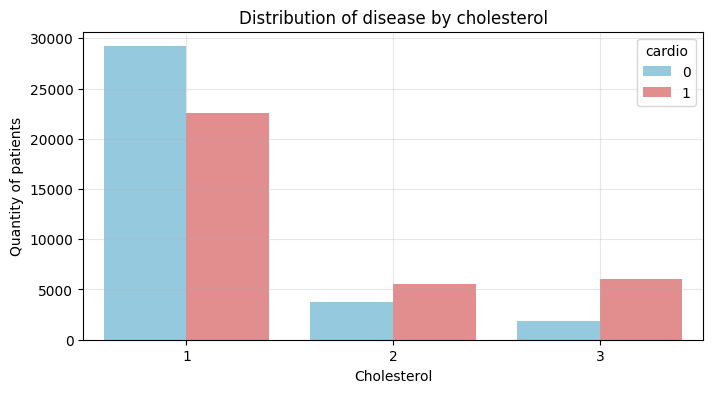

In [ ]:
plot_bar_by_label(data, 'cholesterol')

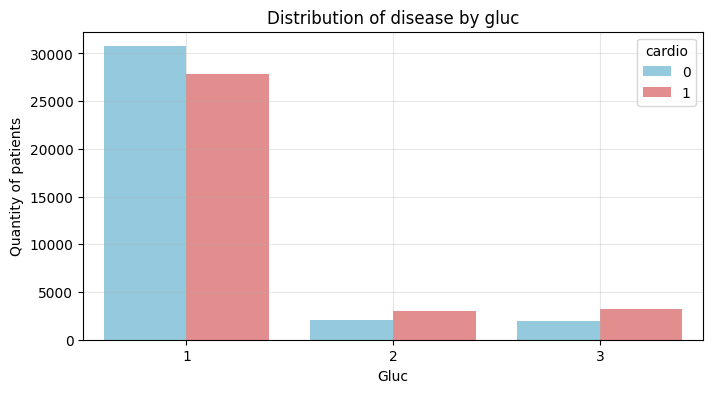

In [ ]:
plot_bar_by_label(data, 'gluc')

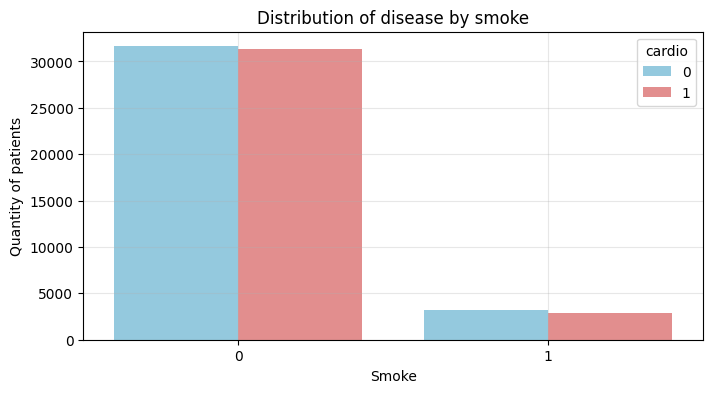

In [ ]:
plot_bar_by_label(data, 'smoke')

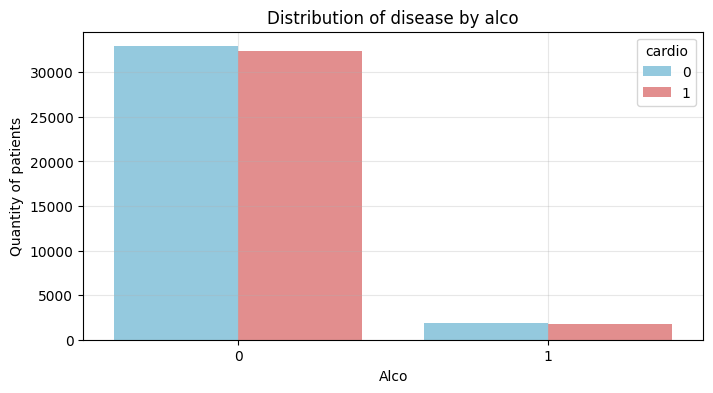

In [ ]:
plot_bar_by_label(data, 'alco')

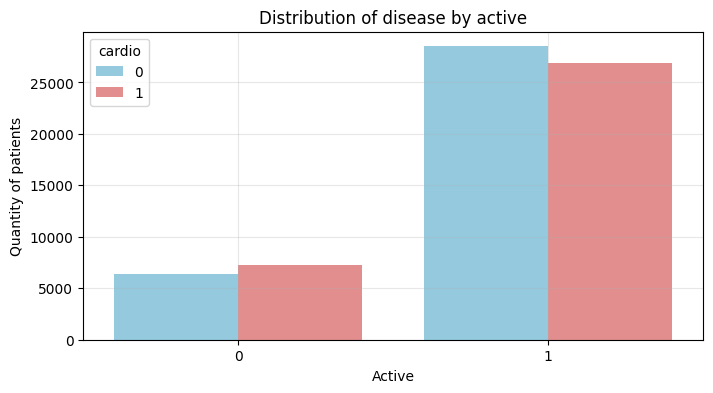

In [ ]:
plot_bar_by_label(data, 'active')

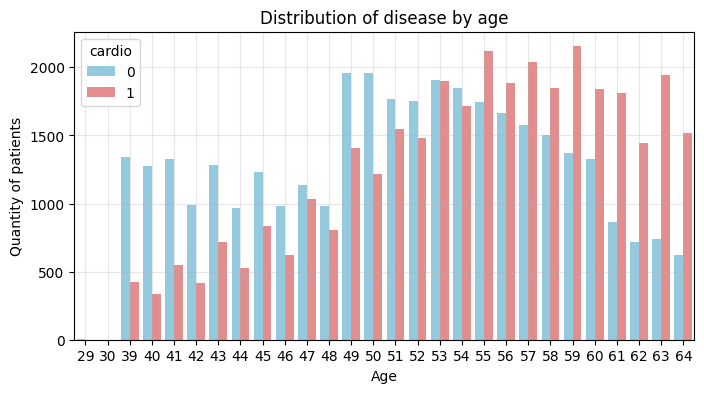

In [ ]:
data2 = data.copy()
data2["age"] = data2["age"].astype(int)
plot_bar_by_label(data2, 'age')


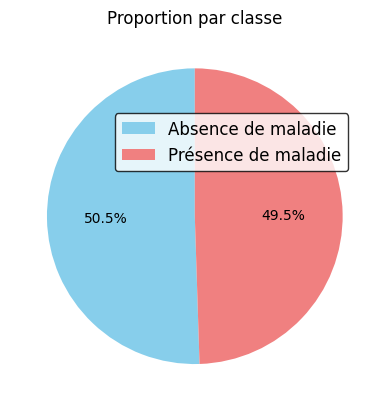

In [ ]:
# On calcule le nombre d’occurrences de chaque valeur de la variable cible 'cardio'
conteo = data['cardio'].value_counts()

# On crée un graphique en secteurs pour représenter la proportion
# de patients avec et sans maladie cardiovasculaire
plt.pie(
    conteo,  # étiquettes des deux classes
    autopct='%1.1f%%',         # format d’affichage des pourcentages
    startangle=90,             # angle de départ pour tourner le camembert
    colors=['skyblue', 'lightcoral'],  # couleurs pour chaque catégorie
)

# On ajoute un titre décrivant le contenu du graphique
plt.title('Proportion par classe')

plt.legend(
    ['Absence de maladie', 'Présence de maladie'],
    loc='center',
    bbox_to_anchor=(0.60, 0.70),
    frameon=True,
    facecolor='white',
    edgecolor='black',
    fontsize=12
)


# On affiche le graphique à l’écran
plt.show()

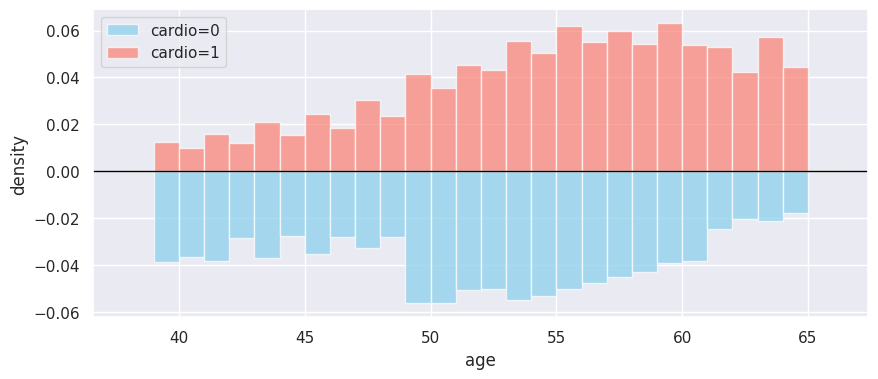

In [ ]:
# Histogrammes miroir (densité) selon la classe cardio
sns.set_theme()  # applique un style seaborn par défaut

# Bornes des bins (classes) de largeur 1 an : de 38 jusqu’à l’âge max (+ marge)
bins = np.arange(38, data["age"].max() + 2, 1)

# Création de la figure
fig, ax = plt.subplots(figsize=(10, 4))

# Boucle sur les deux classes de cardio :
#  - cardio=0 affiché vers le bas (sign = -1)
#  - cardio=1 affiché vers le haut (sign = +1)
for val, color, sign in [(0, "skyblue", -1), (1, "salmon", +1)]:
    # Sélection des âges correspondant à la classe cardio=val
    x = data.loc[data["cardio"] == val, "age"].dropna().to_numpy()

    # Calcul de l’histogramme en densité (aire totale = 1)
    h, edges = np.histogram(x, bins=bins, density=True)

    # Centres des bins (pour placer les barres au milieu de chaque intervalle)
    centers = (edges[:-1] + edges[1:]) / 2

    # Tracé des barres : sign*h permet de faire un histogramme "miroir"
    ax.bar(
        centers,
        sign * h,
        width=1,
        color=color,
        alpha=0.7,
        label=f"cardio={val}"
    )

# Ligne horizontale à 0 : séparation visuelle entre les deux distributions
ax.axhline(0, color="black", linewidth=1)

# Labels et légende
ax.set_xlabel("age")
ax.set_ylabel("density")
ax.legend()

# Affichage
plt.show()


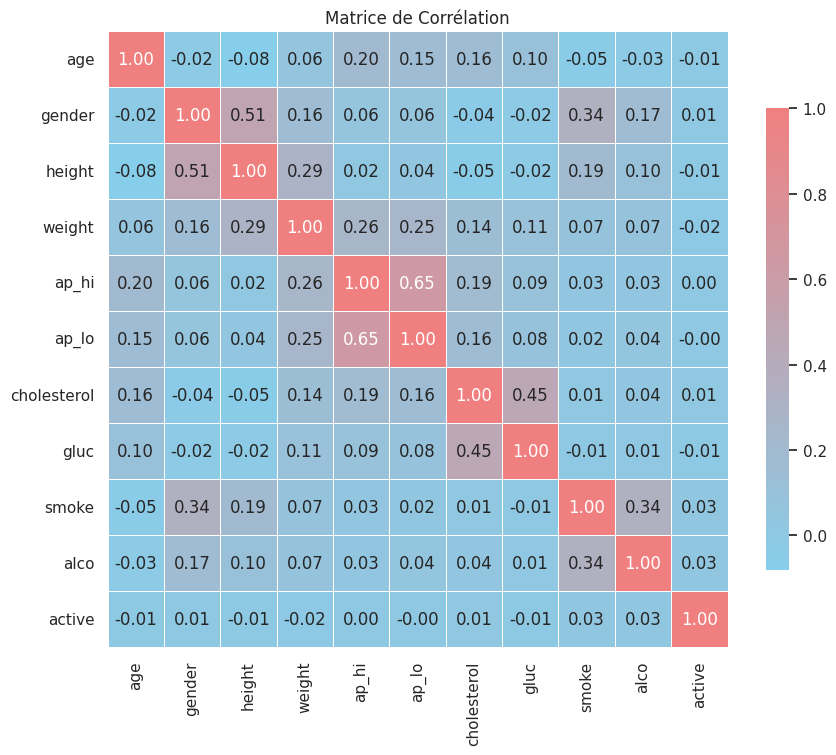

In [ ]:
# Calculer la matrice de corrélation entre toutes les variables numériques
correlation_matrix = data.drop(columns=['cardio']).corr()

# Définir une palette de couleurs personnalisée basée sur les couleurs de ton graphique
custom_cmap = LinearSegmentedColormap.from_list("skyblue_lightcoral", ['skyblue', 'lightcoral'])

# Créer un graphique de la matrice de corrélation
plt.figure(figsize=(10, 8))  # Ajuster la taille de la figure si nécessaire
sns.heatmap(
    correlation_matrix,                                       # La matrice de corrélation
    annot=True,                                               # Afficher les valeurs dans chaque cellule
    cmap=custom_cmap,                                         # Choisir un schéma de couleurs
    fmt='.2f',                                                # Format des nombres à afficher
    linewidths=0.5,                                           # Épaisseur des lignes de séparation
    cbar_kws={'shrink': 0.75}                                 # Ajuster la taille de la barre de couleur
)

# Ajouter un titre au graphique
plt.title('Matrice de Corrélation')

# Afficher le graphique
plt.show()

La base de données a déjà été analysée et nettoyée; nous allons maintenant commencer à développer et à tester les algorithmes vus en cours pour prédire la présence ou l'absence de maladie cardiaque.

## PARTIE III : Validation croisée et évaluation des modèles

Modèles :
*   Classifieur Euclidien
*   Classifieur des plus proches voisins
*   Naive Bayes
*   QDA
*   LDA
*   Régression Logistique
*   Régression Logistique post LASSO
*   Decision tree






In [ ]:
def modelEucledian(Xtrain, Ytrain, Xtest):

    # On crée un classifieur basé sur la distance euclidienne au centroïde de chaque classe
    Eucledian = NearestCentroid()

    # On entraîne le classifieur sur les données d'entraînement
    Eucledian.fit(Xtrain, Ytrain)

    # On prédit les étiquettes des données de test en utilisant les centroïdes appris
    YhatTrain = Eucledian.predict(Xtrain)
    YhatTest = Eucledian.predict(Xtest)

    # On renvoie les prédictions
    return YhatTrain, YhatTest

In [ ]:
def modelPPV(Xtrain, Ytrain, Xtest, q):
    # On crée un classifieur k-NN avec q voisins
    neigh = KNeighborsClassifier(q)

    # On entraîne le modèle sur les données d'entraînement
    neigh.fit(Xtrain, Ytrain)

    # On prédit les étiquettes pour les données de test
    YhatTrain = neigh.predict(Xtrain)
    YhatTest = neigh.predict(Xtest)

    # On renvoie les prédictions obtenues
    return YhatTrain, YhatTest

In [ ]:
#Fonction permettant de déterminer le nombre optimal de voisins à utiliser pour le classificateur PPV
def Koptimal(X,YR):
  # Nous utilisons la fonction de perte L01
  Y_set = np.unique(YR)
  K = len(Y_set)
  L = np.ones((K,K)) - np.eye(K)

  nbFolds = 4
  kf = KFold(n_splits=nbFolds, shuffle=True)
  kfSplit = kf.split(X)

  # Nombre de voisins testés pour le modèle KNN
  stock_kn = np.array([1, 10, 20, 30, 40, 50, 100])
  nb_kn = stock_kn.shape[0]

  # Matrices pour stocker le risque moyen (erreur) pour chaque fold et chaque k
  stock_average_risk_Train = np.zeros((nbFolds,nb_kn))
  stock_average_risk_Val = np.zeros((nbFolds,nb_kn))

  f = 0
  t = 0

  # Boucle sur les différentes partitions (folds) de la validation croisée
  for train, val in kfSplit:

        print("processing fold f =", f)

        # Séparation des données en ensemble d'entraînement et ensemble de validation
        XTrain, XVal, YRTrain, YRVal = X.iloc[train,:], X.iloc[val,:], YR.iloc[train], YR.iloc[val]

        # Boucle sur les différentes valeurs de k (nombre de voisins)
        for kn in stock_kn:

            print("    KNN -> kn =", kn)

            # Création du modèle KNN avec kn voisins et distance euclidienne
            model_KNN = KNeighborsClassifier(n_neighbors=kn, metric='euclidean')

            # Entraînement du modèle sur les données d'entraînement
            model_KNN.fit(XTrain, YRTrain)

            # Prédiction sur les données d'entraînement
            YhatTrainKNN = model_KNN.predict(XTrain)
            stock_average_risk_Train[f,t] = compute_average_risk(YRTrain, YhatTrainKNN, Y_set, L)

            # Prédiction sur les données de validation
            YhatValKNN = model_KNN.predict(XVal)
            stock_average_risk_Val[f,t] = compute_average_risk(YRVal, YhatValKNN, Y_set, L)

            # On passe à l’indice suivant pour stocker les résultats
            t = t+1

        f = f+1
        t = 0

  # FiGURE RISQUE MOYEN VERSUS NOMBRE DE VOISINS :
  fig_select_kn = plt.figure(figsize=(6,6))
  ax1 = fig_select_kn.add_subplot(1,1,1)
  ax1.plot(stock_kn, np.mean(stock_average_risk_Train,0), color='blue', label='Training')
  ax1.plot(stock_kn, np.mean(stock_average_risk_Train,0)-np.std(stock_average_risk_Train,0), color='blue',ls='--')
  ax1.plot(stock_kn, np.mean(stock_average_risk_Train,0)+np.std(stock_average_risk_Train,0), color='blue',ls='--')

  ax1.plot(stock_kn, np.mean(stock_average_risk_Val,0), color='orange', label='Validation')
  ax1.plot(stock_kn, np.mean(stock_average_risk_Val,0)-np.std(stock_average_risk_Val,0), color='orange',ls='--')
  ax1.plot(stock_kn, np.mean(stock_average_risk_Val,0)+np.std(stock_average_risk_Val,0), color='orange',ls='--')
  ax1.legend(fontsize=20, loc='lower right')
  ax1.set_xlabel("Nombre de voisins",fontsize=20)
  ax1.set_ylabel("Risque d'erreur empirique",fontsize=20)
  ax1.set_title("Sélection du nombre de voisins optimal",fontsize=20)
  ax1.tick_params(axis='x', labelsize=20)
  ax1.tick_params(axis='y', labelsize=20)
  ax1.set_xlim([np.min(stock_kn),np.max(stock_kn)])
  ax1.grid()


In [ ]:
def modelCNB(XTrain,YTrain,XTest):
  CNB = GaussianNB() #La premier fonction de CNB
  CNB.fit(XTrain, YTrain)
  # La fonction fit calcule pour chaque classe :
  #  - la moyenne (μ) et la variance (σ²) de chaque variable
  #  - la probabilité a priori (prior) de la classe
  YhatTrain = CNB.predict(XTrain)
  YhatTest = CNB.predict(XTest)

  return YhatTrain, YhatTest

In [ ]:
def modelQDA(XTrain,YTrain,XTest):
  QDA = QuadraticDiscriminantAnalysis()
  QDA.fit(XTrain, YTrain)
  # Pour QDA, il calcule pour chaque classe :
  #  - le vecteur des moyennes (μ)
  #  - la matrice de covariance (Σ)
  #  - la probabilité a priori de la classe

  YhatTrain = QDA.predict(XTrain)
  YhatTest = QDA.predict(XTest)

  return YhatTrain, YhatTest

In [ ]:
def modelLDA(XTrain,YTrain,XTest):
# Les variables doitent etre numeriques
  LDA = LinearDiscriminantAnalysis()
  LDA.fit(XTrain, YTrain)
  #  Pour LDA, il calcule :
  #  - la moyenne de chaque classe
  #  - une seule matrice de covariance commune à toutes les classes
  YhatTrain = LDA.predict(XTrain)
  YhatTest = LDA.predict(XTest)

  return YhatTrain, YhatTest

In [ ]:
# On définit une fonction qui entraîne une régression logistique
def modelRegressionLogistic(Xtrain, Ytrain, Xtest):
    # On crée un modèle de régression logistique avec une graine aléatoire fixée
    # puis on l’entraîne sur les données d’entraînement
    model = LogisticRegression(random_state=0).fit(Xtrain, Ytrain)
    # On prédit les étiquettes pour les données d’entraînement
    Yhattrain = model.predict(Xtrain)
    # On prédit les étiquettes pour les données de test
    Yhattest = model.predict(Xtest)
    # On renvoie les prédictions sur l’entraînement et sur le test
    return Yhattrain, Yhattest

In [ ]:
def Analyse_variables_necessaires(XTrain, YTrain):

    np.random.seed(407)

   # Nombre de variables dans XTrain
    d = XTrain.shape[1]

    # Nombre d'observations dans l'échantillon d'entraînement
    nTrain = XTrain.shape[0]

    # Pas utilisé pour générer les valeurs de lambda
    step = 0.01

    # Création d'un ensemble de valeurs de lambda entre 0.0001 et 1
    stock_lambda = np.arange(0.0001, 1, step)

    # Nombre total de valeurs de lambda testées
    nb_lambda = stock_lambda.shape[0]

    # Matrice pour stocker les coefficients (bêta) pour chaque lambda
    stock_beta = np.zeros((nb_lambda, d))

    # Tableau pour stocker l'accuracy sur l’échantillon d'entraînement
    stock_average_risk_Train = np.zeros(nb_lambda)

    # Compteur permettant de remplir les tableaux au bon index
    l = 0


    # Boucle sur toutes les valeurs de lambda
    for lmbda in stock_lambda:

        # Modèle de régression logistique avec pénalité L1 (Lasso)
        # Le paramètre C est l’inverse de la force de régularisation
        LR_model = LogisticRegression(
            penalty='l1', solver='saga', C=lmbda, max_iter=10000
        )

        # Entraînement du modèle sur les données
        LR_model.fit(XTrain, YTrain)

        # Prédictions du modèle sur l’échantillon d'entraînement
        Yhat = LR_model.predict(XTrain)

        # Calcul de l'accuracy : proportion de bonnes prédictions
        stock_average_risk_Train[l] = np.sum(YTrain == Yhat) / nTrain

        # Stockage des coefficients du modèle pour cette valeur de lambda
        stock_beta[l] = LR_model.coef_

        # Passage à l'index suivant
        l = l + 1

    lambda_max_acc = stock_lambda[np.argmax(stock_average_risk_Train)]
    #attention : lambda_max_acc n'est pas l'optimal, sinon celle qui nous donne l'accuracy maximale.

        # FiGURE - graphiques qui résument les valeurs de betas pour chaque lambda, ainsi que l'accuracy pour chaque lambda.
    fig_select_lambda = plt.figure(figsize=(18,7))

    ax1 = fig_select_lambda.add_subplot(1,3,1)
    for j in range(d):
        labelstring = "beta_"+str(j+1)
        ax1.plot(stock_lambda, stock_beta[:,j], lw=2, label=labelstring)
    ax1.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))
    ax1.set_xlabel("Régularisation $ c = 1/ \lambda$",fontsize=20)
    ax1.set_ylabel("Beta",fontsize=20)
    ax1.set_title("Beta versus $\lambda$",fontsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlim([np.min(stock_lambda),np.max(stock_lambda)])
    ax1.grid()
    ax1.set_xscale('log')

    ax2 = fig_select_lambda.add_subplot(1,3,3)
    ax2.plot(stock_lambda, stock_average_risk_Train, lw=2, color='red', label='Accuracy Training')
    ax2.legend(fontsize=20, loc='lower right')
    ax2.set_xlabel("Régularisation $c = 1/ \lambda$",fontsize=20)
    ax2.set_ylabel("Accuracy Train",fontsize=20)
    ax2.set_title("Accuracy versus $\lambda$",fontsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([np.min(stock_lambda),np.max(stock_lambda)])
    ax2.grid()
    ax2.set_xscale('log')

    return lambda_max_acc

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:77: SyntaxWarning: invalid escape sequence '\l'
<>:79: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:77: SyntaxWarning: invalid escape sequence '\l'
<>:79: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2917204023.py:65: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel("Régularisation $ c = 1/ \lambda$",fontsize=20)
/tmp/ipython-input-2917204023.py:67: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_title("Beta versus $\lambda$",fontsize=20)
/tmp/ipython-input-2917204023.py:77: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_xlabel("Régularisation $c = 1/ \lambda$",fontsize=20)
/tmp/ipython-input-2917204023.py:79: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_title("Accuracy versus $\lambda$",fontsize=20)


In [ ]:
def selectTree(Xtrain, Ytrain, Xtest, Ytest):
    # On crée un modèle d'arbre de décision avec une graine aléatoire fixée
    model = tree.DecisionTreeClassifier(random_state=0)

    # On calcule le chemin de "cost complexity pruning"
    # Cette fonction renvoie les valeurs possibles de ccp_alpha
    # et les impuretés correspondantes pour élaguer l'arbre
    path = model.cost_complexity_pruning_path(Xtrain, Ytrain)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    # On initialise une liste pour stocker les différents modèles
    models = []
    # Pour chaque valeur de ccp_alpha proposée par le chemin de pruning
    for ccp_alpha in ccp_alphas:
        # On crée un nouvel arbre de décision avec ce ccp_alpha
        model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        # On entraîne ce modèle sur les données d'entraînement
        model.fit(Xtrain, Ytrain)
        # On ajoute le modèle entraîné à la liste
        models.append(model)

    # On calcule l'accuracy sur l'entraînement pour chaque modèle
    train_scores = [model.score(Xtrain, Ytrain) for model in models]
    # On calcule l'accuracy sur le test pour chaque modèle
    test_scores = [model.score(Xtest, Ytest) for model in models]

    # On crée une figure et un axe pour tracer les courbes
    fig, ax = plt.subplots()
    # On nomme l’axe des abscisses (alpha)
    ax.set_xlabel("alpha")
    # On nomme l’axe des ordonnées (accuracy)
    ax.set_ylabel("accuracy")
    # On donne un titre au graphique
    ax.set_title("Accuracy vs alpha for training and testing sets")

    # On trace l’accuracy d’entraînement en fonction de ccp_alpha
    ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    # On trace l’accuracy de test en fonction de ccp_alpha
    ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")

    # On affiche la légende pour distinguer train et test
    ax.legend()
    # On affiche la figure à l'écran
    plt.show()

In [ ]:
# On définit une fonction qui entraîne un arbre de décision
# alpha  : paramètre de complexité (ccp_alpha) pour l’élagage
# df     : DataFrame contenant les noms des variables explicatives
def modelDesicionTree(Xtrain, Ytrain, Xtest, alpha, df):
    # On crée un arbre de décision avec une graine aléatoire fixée
    # et un paramètre d’élagage ccp_alpha = alpha
    model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    # On entraîne le modèle sur les données d’entraînement
    model = model.fit(Xtrain, Ytrain)

    # On prédit les étiquettes pour les données d’entraînement
    YhatTrain = model.predict(Xtrain)
    # On prédit les étiquettes pour les données de test
    YhatTest = model.predict(Xtest)

    # Première exportation du graphe (version simple, sans noms de variables)
    dot_data = tree.export_graphviz(model, out_file=None)
    graph = graphviz.Source(dot_data)

    # Deuxième exportation du graphe avec noms de variables et options graphiques
    dot_data = tree.export_graphviz(
        model,
        out_file=None,
        feature_names=df.columns.values[0:11],   # noms des 11 premières variables
        class_names=['Non-Disease', 'Disease'],  # noms des classes
        filled=True,                             # couleur en fonction des classes
        rounded=True,                            # boîtes aux coins arrondis
        special_characters=True                  # support de caractères spéciaux
    )
    # On crée un objet graphviz à partir des données .dot
    graph = graphviz.Source(dot_data)
    # On enregistre le graphe dans un fichier (PDF/PNG selon config)
    graph.render("Cardiaque_disease_DT_élagué")
    # On retourne l’objet graph pour un affichage éventuel dans un notebook
    graph

    # On renvoie les prédictions sur l’entraînement et sur le test
    return YhatTrain, YhatTest

In [ ]:
# On définit l’ensemble des étiquettes possibles (ici deux classes : 0 et 1)
Y_set = np.array([0, 1])

# On définit la matrice de perte L associée aux prédictions :
# L[i, j] représente le coût de prédire la classe j lorsque la vraie classe est i
# Ici :
# - L[0,1] = 1 : coût si on prédit 1 alors que la classe réelle est 0
# - L[1,0] = 1 : coût si on prédit 0 alors que la classe réelle est 1
# - L[0,0] = 0 et L[1,1] = 0 : aucun coût si la prédiction est correcte
L = np.array([[0, 1],
              [1, 0]])

In [ ]:
# On configure les différents objets EmissionsTracker,
# chacun correspondant à un modèle de machine learning différent.
# Chaque tracker permet de mesurer l’empreinte carbone générée
# pendant l’entraînement et les prédictions d’un modèle spécifique.

%%capture --no-display

# Tracker pour le modèle Eucledian (méthode du centroïde le plus proche)
tracker_Eucledian = EmissionsTracker(project_name='modelEucledian', save_to_file=False)

# Tracker pour le modèle des plus proches voisins (PPV / KNN)
tracker_PPV = EmissionsTracker(project_name='modelPPV', save_to_file=False)

# Tracker pour le classifieur naïf bayésien (Complement Naive Bayes)
tracker_CNB = EmissionsTracker(project_name='modelCNB', save_to_file=False)

# Tracker pour l’analyse discriminante quadratique (QDA)
tracker_QDA = EmissionsTracker(project_name='modelQDA', save_to_file=False)

# Tracker pour l’analyse discriminante linéaire (LDA)
tracker_LDA = EmissionsTracker(project_name='modelLDA', save_to_file=False)

# Tracker pour la régression logistique
tracker_RegressionLogistic = EmissionsTracker(project_name='modelRegressionLogistic', save_to_file=False)

# Tracker pour la régression logistique après le LASSO
tracker_RegressionLogisticLASSO = EmissionsTracker(project_name='modelRegressionLogisticLASSO', save_to_file=False)

# Tracker pour l’arbre de décision (Decision Tree)
tracker_DesicionTree = EmissionsTracker(project_name='modelDesicionTree', save_to_file=False)




[codecarbon WARNING @ 21:53:51] Multiple instances of codecarbon are allowed to run at the same time.


In [ ]:
# Nous allons utiliser juste 5000 observations pour la validation croissée à cause du temps d'éxecution. Le reste (65000) sera utilisé pour des tests.
N_sub = 5000
data_sub = data.sample(n=N_sub, random_state=0)  # échantillon aléatoire de 5000 patients

# On prend que 5000 comme train
data_train, data_test = train_test_split(data, train_size=5000, random_state=10, shuffle=True)

YR = data_train['cardio']
X  = data_train.drop(columns=['cardio'])

Ytests_additionels = data_test['cardio']
Xtests_additionels  = data_test.drop(columns=['cardio'])

print("Pour la validation croissée nous utilisons : ", data_sub.shape[0], " observations ")
print("Pour des tests additionels nous utilisons : ", data_test.shape[0], " observations ")

Pour la validation croissée nous utilisons :  5000  observations 
Pour des tests additionels nous utilisons :  63980  observations 


Nous observons qu'un nombre kn de 40 permet d'avoir des erreurs de validation et d'entraînement similaires, tout en conservant un nombre qui n'est pas trop élevé, car cela pourrait nécessiter un temps d'exécution trop long et donc une consommation de CO2 plus importante.

Nous observons qu’en analysant le classifieur d’arbre de décision, une valeur d’alpha = 0,005 nous permet d’obtenir des valeurs d’accuracy de validation et d’entraînement similaires, tout en obtenant un arbre équilibré et pas très grand.

In [ ]:
#DÉCLARATION DE VARIABLES
nbFolds = 4

kf = KFold(n_splits=nbFolds, shuffle=True)
# IMPORTANT : on convertit en liste pour pouvoir réutiliser les folds plusieurs fois
splits = list(kf.split(X))

train_idx, val_idx = splits[0]   # premier fold, mais elles ont toutes les mêmes longueuers

Ntrain = len(train_idx) # longueur de chaque fold utilisée comme train
Ntest = len(val_idx) # longueur de chaque fold utilisée comme test

# Pour chaque modèle, nous faisons des matrices qui vont stocker les prédictions de chaque fold

YhatTrainEucledian = np.zeros((nbFolds, Ntrain))
YhatTestEucledian  = np.zeros((nbFolds, Ntest))

YhatTrainPPV = np.zeros((nbFolds, Ntrain))
YhatTestPPV = np.zeros((nbFolds, Ntest))

YhatTrainCNB = np.zeros((nbFolds, Ntrain))
YhatTestCNB  = np.zeros((nbFolds, Ntest))

YhatTrainQDA = np.zeros((nbFolds, Ntrain))
YhatTestQDA  = np.zeros((nbFolds, Ntest))

YhatTrainLDA = np.zeros((nbFolds, Ntrain))
YhatTestLDA  = np.zeros((nbFolds, Ntest))

Yhattrain_Rlogistique = np.zeros((nbFolds, Ntrain))
Yhattest_Rlogistique  = np.zeros((nbFolds, Ntest))

YhattrainDT = np.zeros((nbFolds, Ntrain))
YhattestDT  = np.zeros((nbFolds, Ntest))

Yhattrain_RlogistiqueLASSO = np.zeros((nbFolds, Ntrain))
Yhattest_RlogistiqueLASSO  = np.zeros((nbFolds, Ntest))

# quantité de modèls à évaluer
quant_models = 8

# Matrices pour stocker les statistiques pour chaque fold et chaque k
# chaque ligne est destinée à chaque fold, chaque colonne est destinée à la valeur
# de chaque modèle. Comme ça, nous pouvons stocker par ex l'erreur de chaque modèle
# pour chaque fold.
stock_risk_Train = np.zeros((nbFolds, quant_models))
stock_risk_Val   = np.zeros((nbFolds, quant_models))
stock_acc_Train   = np.zeros((nbFolds, quant_models))
stock_acc_Val   = np.zeros((nbFolds, quant_models))
stock_accParClass_Train   = np.zeros((nbFolds, len(Y_set), quant_models))
stock_accParClass_Val   = np.zeros((nbFolds,len(Y_set), quant_models))
stock_riskParClass_Train = np.zeros((nbFolds, len(Y_set), quant_models))
stock_riskParClass_Val = np.zeros((nbFolds, len(Y_set), quant_models))
stock_confusion_train = np.zeros((nbFolds, quant_models, len(Y_set), len(Y_set)))
stock_confusion_test  = np.zeros((nbFolds, quant_models, len(Y_set), len(Y_set)))

q = 40  # quantité optimale de plus proches voisins obtenue

alfa = 0.005 # valeur d'alpha optimale pour le classifier d'arbe de decission

# Matrices pour stocker les vraies étiquettes par fold
YRTrain_matriz = np.zeros((nbFolds, Ntrain))
YRTest_matriz  = np.zeros((nbFolds, Ntest))

# Arrays para guardar las emisiones por fold de cada modèle
emissions_models = np.zeros((nbFolds, quant_models))



In [ ]:
print("shape train:", YhatTrainCNB.shape, "shape test", YhatTestCNB.shape)

shape train: (4, 3750) shape test (4, 1250)


Toutes les variables ont un rôle important dans la classification par REGRESSION LOGISTIQUE ? Nous pouvons le vérifier à partir de l'algorithme de LASSO vu en cours et TD, implementé dans la fonction "Analyse_variables_necessaires" :

processing fold f = 0
lambda trouvé pour fold f = 0 :  0.2701
processing fold f = 1
lambda trouvé pour fold f = 1 :  0.0001
processing fold f = 2
lambda trouvé pour fold f = 2 :  0.0001
processing fold f = 3
lambda trouvé pour fold f = 3 :  0.7601


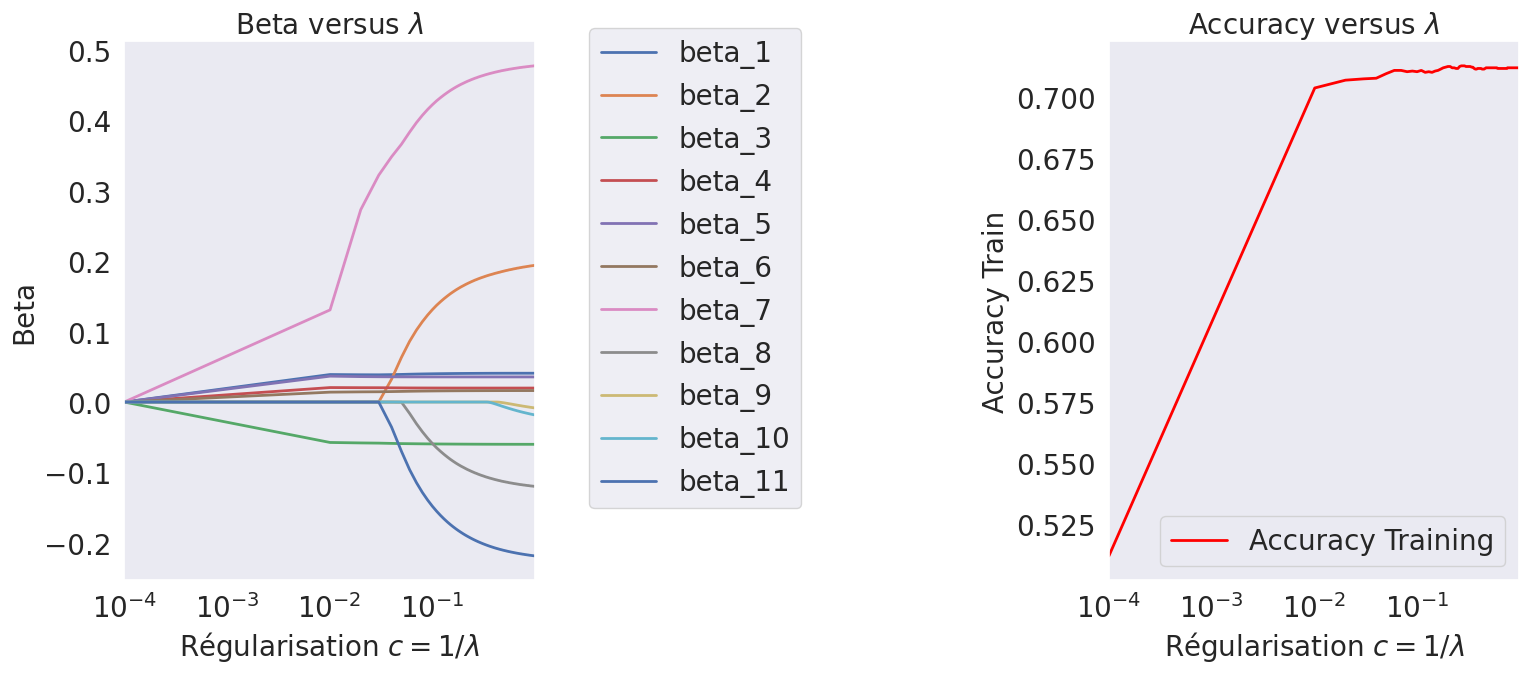

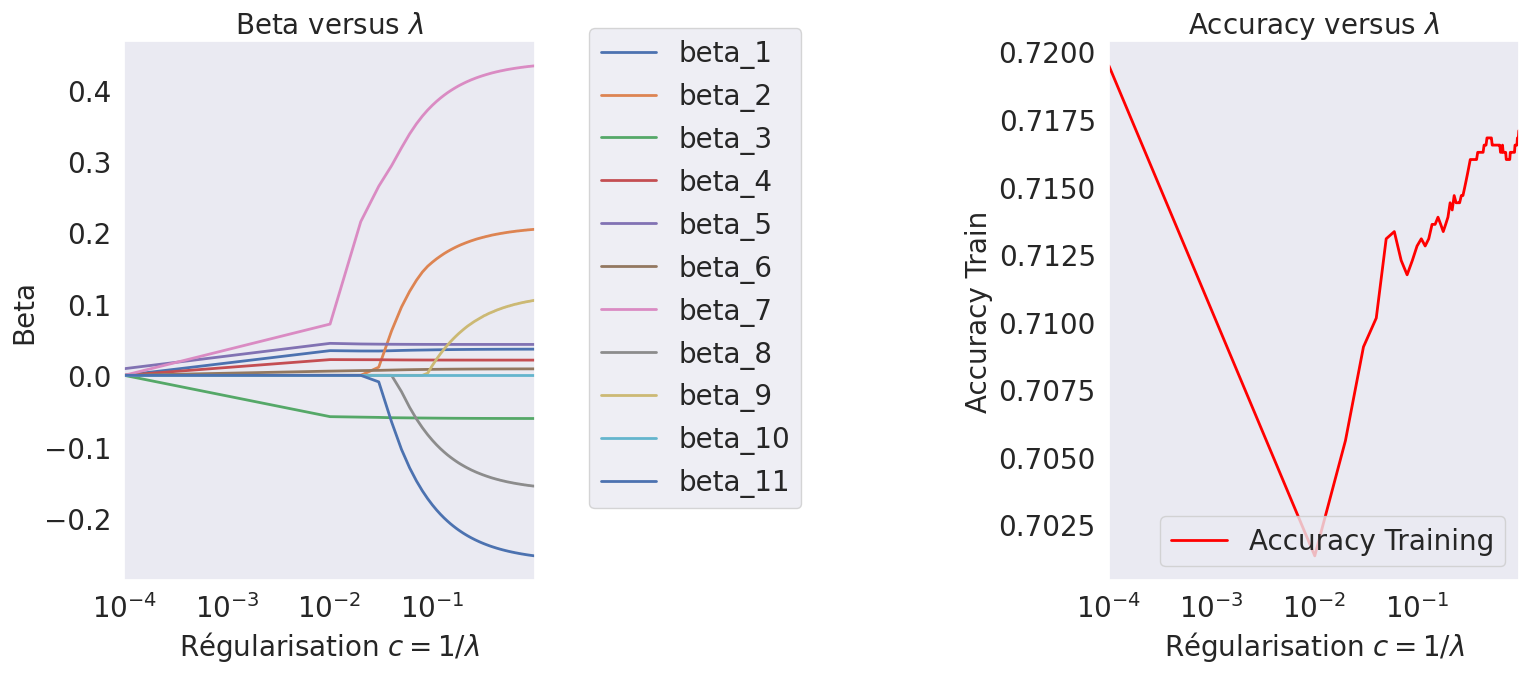

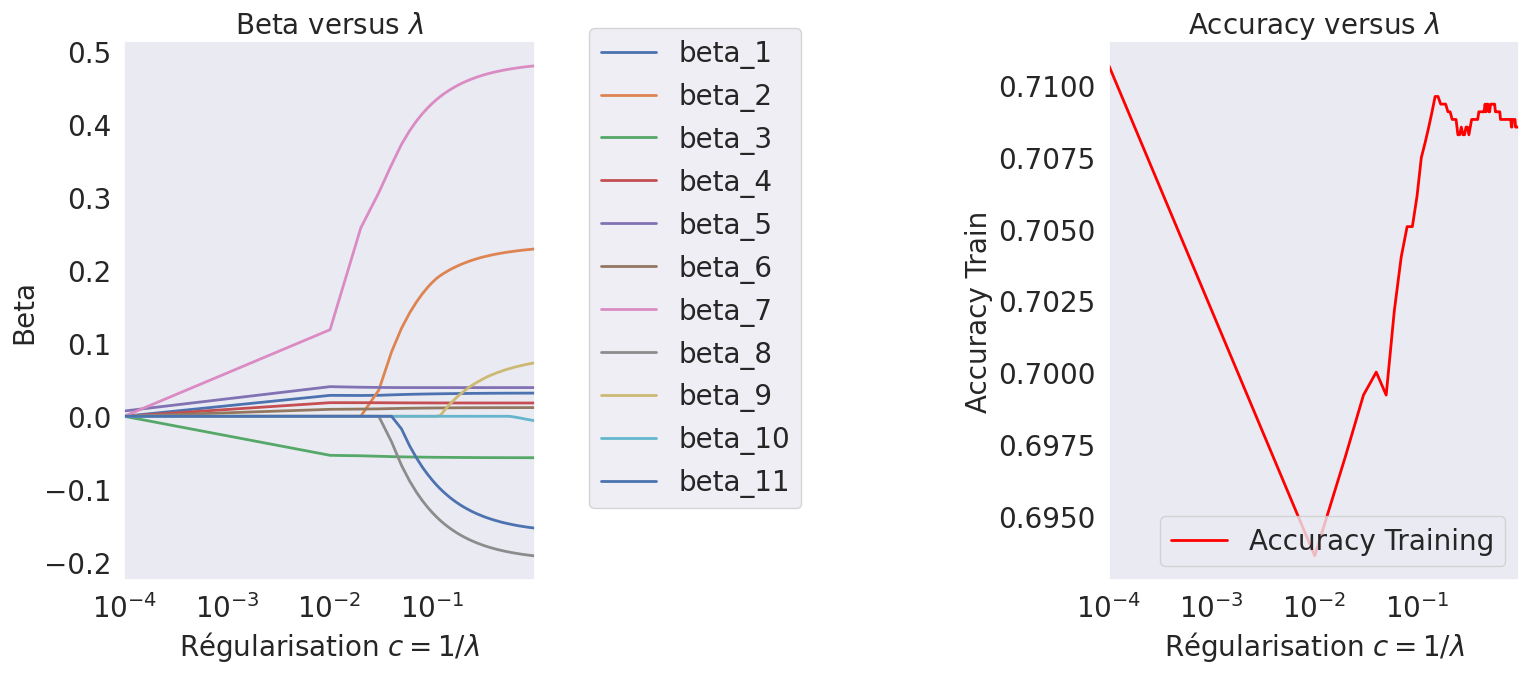

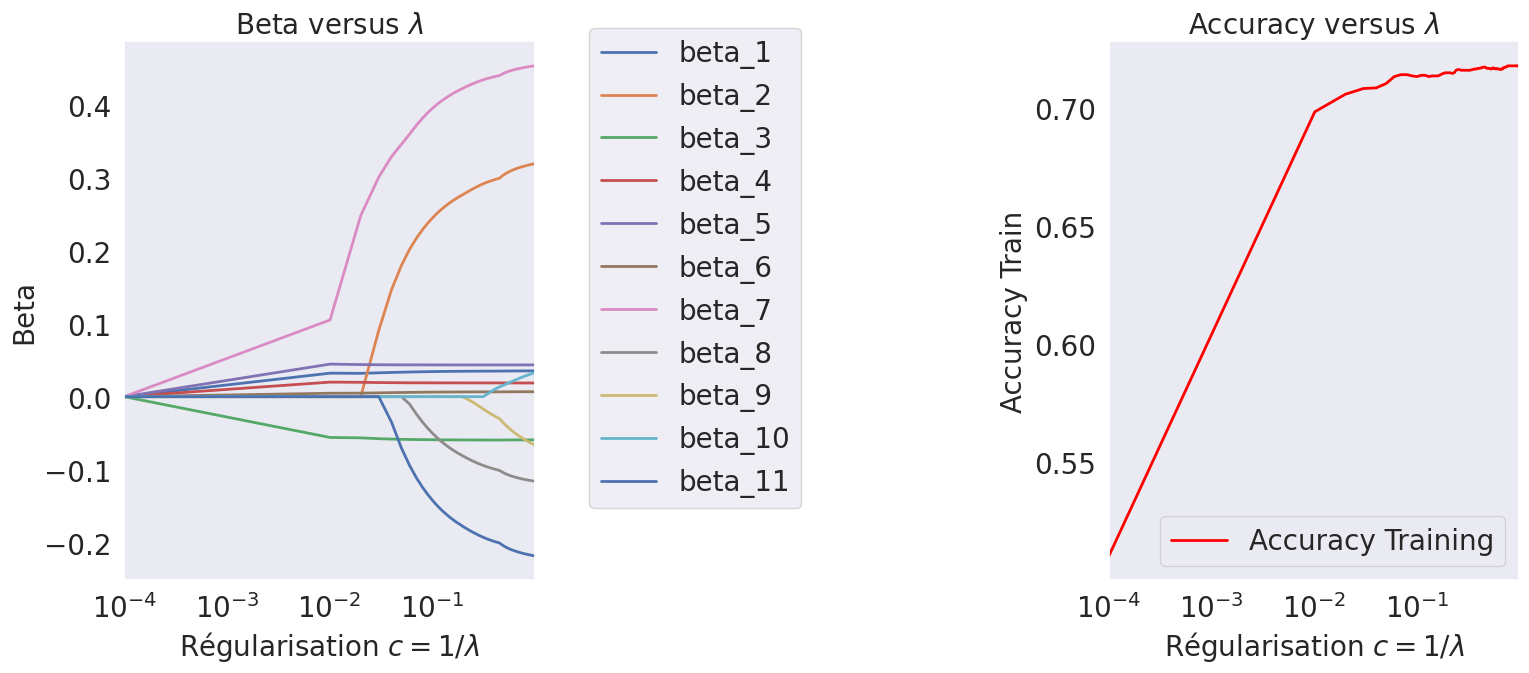

In [ ]:


f = 0
lambda_max = np.zeros(nbFolds)

# Boucle sur les différentes partitions (folds) de la validation croisée
for f, (train, val) in enumerate(splits):

      print("processing fold f =", f)

      # Séparation des données en ensemble d'entraînement et ensemble de validation
      XTrain, XVal = X.iloc[train, :], X.iloc[val, :]
      YRTrain, YRVal = YR.iloc[train], YR.iloc[val]

      lambda_max[f] = Analyse_variables_necessaires(XTrain, YRTrain)
      print("lambda trouvé pour fold f =" , f, ": ", lambda_max[f])



En interprétant ces graphiques, nous pouvons conclure que les variables 6, 9 et 10, qui correspondent à la pression dyastolique, à la condition de buveur et au tabagisme, n'ont pas d'effet significatif sur la classification par régression logistique. Nous considérons que ces résultats de la méthode LASSO sont incohérents, car de nombreuses études médicales confirment l'influence de fumer sur les maladies cardiovasculaires [1], ainsi que l'effet du boire de l'alcohol[2]. Cela peut indiquer que notre base de données n'est peut-être pas complète ou que toutes les données ne sont pas exactes. Toutefois, ce résultat nous permet d'éliminer les variables mentionnées de notre base de données utilisée pour entraîner la classification par régression logistique, ce qui est censé à réduire le temps de calcul et donc les émissions de CO2.

 [1] [Rahman, M., et al. (2025). Cardiovascular effects of smoking and smoking cessation: A 2024 update. Global Heart.](https://globalheartjournal.com/articles/10.5334/gh.1399)

 [2] [Di Gennaro C, Saccani-Jotti G, Pinelli S, et al. Endothelial dysfunction and high cardiovascular risk profile in severe alcoholics improve only partially following a medium-term alcohol withdrawal. Alcoholism: Clinical and Experimental Research. 2012](https://onlinelibrary.wiley.com/doi/10.1111/j.1530-0277.2011.01636.x)

En plus, notre fonction donne la valeur de lambda pour laquelle l'accuracy est la plus haute MAIS ça ne veut pas dire que c'est le lambda OPTIMALE ! ça va dependre de l'application du logiciel. Dans notre cas, on travail avec des données médicaux et on veut prédire une maladie cardiaque. C'est pour ça que on cherche l'accuracy maximale.

On analyse les lambdas des accuracies maximales pour chaque fold, et nous avons trouvé les valeurs suivants :



In [ ]:
lambda_max

array([2.701e-01, 1.000e-04, 1.000e-04, 7.601e-01])

Selon l'information que nous avons trouvée en internet, qui nous semble cohérent, lorsque les coefficients restent à zéro (au début), la régression logistique cesse d’utiliser les variables et se réduit à un classifieur quasi constant. Dans un jeu de données déséquilibré, ce comportement peut conduire à une accuracy apparemment bonne en prédisant la classe majoritaire dans chaque fold, sans pour autant offrir une réelle capacité de discrimination. C’est pourquoi nos valeurs de lambda maximales se trouvent parfois au tout début, même si cela est trompeur. Heureusement, nous pouvons le détecter en analysant les graphiques accuracy vs lambda et bêtas vs lambda. Dans tous les cas, nous avons retenu comme lambda optimal (car il donne l’accuracy maximale) des valeurs situées à partir de 10⁻¹ vers la droite.

En observant nos graphiques bêta par rapport à lambda et accuracy par rapport à lambda, nous arrivons à la conclusion que la accuracy maximale est également, pour toutes les folds, la accuracy qui nous permet de ne pas tenir compte des trois variables mentionnées, car elles ont une influence assez constante et proche de zéro pour tous les lambdas. C'est pourquoi nous allons supprimer ces 3 variables pour mettre en oeuvre la Régression Logistique.

In [ ]:
# Nous allons faire la validation croissée qui génère des différents valeurs de
# risque selon la fold à analyser en chaque itération, et ces valeurs sont
# stockées dans des matrices de MxN.
# Cette fonction fait donc la moyenne les stats obtenus, et les affiche.

def Stats_valid_croissee(stock_risk_Train, stock_risk_Val,
                         stock_acc_Train, stock_acc_Val,
                         stock_accParClass_Train, stock_accParClass_Val,
                         stock_riskParClass_Train, stock_riskParClass_Val,
                         stock_confusion_train,stock_confusion_test,
                         emissions_models,
                         Y_set, models) :

  #quantité de folds analysés (lignes des matrices)
  N = stock_risk_Train.shape[0]

  # quantité de modèles analysés (colonnes des matrices)
  M = len(models)

  Nclass = len(Y_set)

  Erreur_moy_test = np.zeros(M)
  Erreur_moy_train = np.zeros(M)

  Acc_moy_train = np.zeros(M)
  Acc_moy_test = np.zeros(M)

  # pour chaque modèle (ligne) et pour chaque classe (colonne)
  Acc_per_class_moy_train = np.zeros((M, Nclass))
  Acc_per_class_moy_test = np.zeros((M, Nclass))
  Risk_per_class_moy_train = np.zeros((M, Nclass))
  Risk_per_class_moy_test = np.zeros((M, Nclass))

  #matrices de confusion pour chaque modèle, avec la taille Nclass x Nclass
  confusion_moy_train = np.zeros((M, Nclass, Nclass))
  confusion_moy_test  = np.zeros((M, Nclass, Nclass))

  emissions_models_mean = np.zeros(M)

  # pour chaque model nous faisons la moyenne et nous affichons l'erreur
  for i in range (M):
    Erreur_moy_train[i] = np.mean(stock_risk_Train[:,i])
    Erreur_moy_test[i] = np.mean(stock_risk_Val[:,i])

    Acc_moy_train[i] = np.mean(stock_acc_Train[:,i])
    Acc_moy_test[i] = np.mean(stock_acc_Val[:,i])

    confusion_moy_train[i, :, :] = np.mean(stock_confusion_train[:, i, :, :], axis=0)
    confusion_moy_test[i,  :, :] = np.mean(stock_confusion_test[:,  i, :, :], axis=0)

    emissions_models_mean[i] = np.mean(emissions_models[:,i])

    for j in range(Nclass): # pour chaque classe on calcul la moyenne de l'acc et risk
      Acc_per_class_moy_train[i,j] = np.mean(stock_accParClass_Train[:,j,i])
      Acc_per_class_moy_test[i,j] = np.mean(stock_accParClass_Val[:,j,i])
      Risk_per_class_moy_train[i,j] = np.mean(stock_riskParClass_Train[:,j,i])
      Risk_per_class_moy_test[i,j] = np.mean(stock_riskParClass_Val[:,j,i])



    print(models[i], " : ")
    print("Erreur moyenne dans la base TRAIN : ", f"{Erreur_moy_train[i]:.3f}" )
    print("Erreur moyenne dans la base TEST : ", f"{Erreur_moy_test[i]:.3f}" )
    print("Accuracy moyenne dans la base TRAIN : ", f"{Acc_moy_train[i]:.3f}" )
    print("Accuracy moyenne dans la base TEST : ", f"{Acc_moy_test[i]:.3f}" )
    print("Accuracy moyenne par classe dans la base TRAIN : ", Acc_per_class_moy_train[i,:] )
    print("Accuracy moyenne par classe dans la base TEST : ", Acc_per_class_moy_test[i,:] )
    print("Risque moyenne par classe dans la base TRAIN : ", Risk_per_class_moy_train[i,:] )
    print("Risque moyenne par classe dans la base TEST : ", Risk_per_class_moy_test[i,:] )
    print("Matrice de confusion dans la base TRAIN: ", confusion_moy_train[i,:,:])
    print("Matrice de confusion dans la base TEST: ", confusion_moy_test[i,:,:])
    print("EMISSION MOYENNE DE CO2 : ", emissions_models_mean[i],"\n\n" ) ############ agregar la unidad

  return (Erreur_moy_train, Erreur_moy_test, Acc_moy_train, Acc_moy_test, Acc_per_class_moy_train,
   Acc_per_class_moy_test, Risk_per_class_moy_train, Risk_per_class_moy_test,confusion_moy_train, confusion_moy_test, emissions_models_mean)



In [ ]:

# VALIDATION CROISSÉ

# MODÈLES ANALYSÉS :
models = ["Eucledien", "PPV", "CNB", "QDA", "LDA", "REGRESSION LOGISTIQUE", "REG LOGISTIQUE AVEC LASSO", "DECISION TREE"]

f = 0
t = 0
alpha = 0.005


for f, (train, val) in enumerate(splits):


        print("processing fold f =", f)

        # Séparation des données en ensemble d'entraînement et ensemble de validation
        XTrain, XVal = X.iloc[train,:], X.iloc[val,:]
        YRTrain, YRVal = YR.iloc[train], YR.iloc[val]

        # MODÈLE EUCLEDIEN
        tracker_Eucledian.start()
        YhatTrainEucledian[f,:], YhatTestEucledian[f, :] = modelEucledian(XTrain, YRTrain, XVal)
        emissions_models[f,t] = tracker_Eucledian.stop() * 1000  # g CO2eq

        # stat du modèle Eucledien dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, YhatTrainEucledian[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, YhatTestEucledian[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, YhatTrainEucledian[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, YhatTestEucledian[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, YhatTrainEucledian[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, YhatTestEucledian[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, YhatTrainEucledian[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, YhatTestEucledian[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, YhatTrainEucledian[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   YhatTestEucledian[f,:], Y_set)


        t = t+1

        # PPV
        tracker_PPV.start()
        YhatTrainPPV[f, :], YhatTestPPV[f, :] = modelPPV(XTrain, YRTrain, XVal, q)
        emissions_models[f,t] = tracker_PPV.stop() * 1000

        # stat du modèle PPV dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, YhatTrainPPV[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, YhatTestPPV[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, YhatTrainPPV[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, YhatTestPPV[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, YhatTrainPPV[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, YhatTestPPV[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, YhatTrainPPV[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, YhatTestPPV[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, YhatTrainPPV[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   YhatTestPPV[f,:], Y_set)



        t = t+1

        # CNB
        tracker_CNB.start()
        YhatTrainCNB[f, :], YhatTestCNB[f, :] = modelCNB(XTrain, YRTrain, XVal)
        emissions_models[f,t] = tracker_CNB.stop() * 1000

        # stat du modèle CNB dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, YhatTrainCNB[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, YhatTestCNB[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, YhatTrainCNB[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, YhatTestCNB[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, YhatTrainCNB[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, YhatTestCNB[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, YhatTrainCNB[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, YhatTestCNB[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, YhatTrainCNB[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   YhatTestCNB[f,:], Y_set)

        t = t+1

        # QDA et LDA se placent dans un contexte où toutes les variables descriptives sont numériques, nous supprimons donc les variables catégorielles
        XtrainModified = XTrain.drop(columns=['gender','cholesterol','gluc','smoke','alco','active'])
        XtestModified  = XVal.drop(columns=['gender','cholesterol','gluc','smoke','alco','active'])

        # QDA
        tracker_QDA.start()
        YhatTrainQDA[f, :], YhatTestQDA[f, :] = modelQDA(XtrainModified, YRTrain, XtestModified)
        emissions_models[f,t] = tracker_QDA.stop() * 1000

        # stat du modèle QDA dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, YhatTrainQDA[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, YhatTestQDA[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, YhatTrainQDA[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, YhatTestQDA[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, YhatTrainQDA[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, YhatTestQDA[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, YhatTrainQDA[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, YhatTestQDA[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, YhatTrainQDA[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   YhatTestQDA[f,:], Y_set)


        t = t+1

        # LDA
        tracker_LDA.start()
        YhatTrainLDA[f, :], YhatTestLDA[f, :] = modelLDA(XtrainModified, YRTrain, XtestModified)
        emissions_models[f,t] = tracker_LDA.stop() * 1000

        # stat du modèle LDA dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, YhatTrainLDA[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, YhatTestLDA[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, YhatTrainLDA[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, YhatTestLDA[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, YhatTrainLDA[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, YhatTestLDA[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, YhatTrainLDA[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, YhatTestLDA[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, YhatTrainLDA[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   YhatTestLDA[f,:], Y_set)

        t = t+1

        # Regression Logistique
        tracker_RegressionLogistic.start()
        Yhattrain_Rlogistique[f, :], Yhattest_Rlogistique[f, :] = modelRegressionLogistic(XTrain, YRTrain, XVal)
        emissions_models[f,t]= tracker_RegressionLogistic.stop() * 1000

        # risque du modèle LDA dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, Yhattrain_Rlogistique[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, Yhattest_Rlogistique[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, Yhattrain_Rlogistique[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, Yhattest_Rlogistique[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, Yhattrain_Rlogistique[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, Yhattest_Rlogistique[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, Yhattrain_Rlogistique[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, Yhattest_Rlogistique[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, Yhattrain_Rlogistique[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   Yhattest_Rlogistique[f,:], Y_set)

        t = t+1

        # Regression Logistique LASSO, il faut supprimer les variables qui n'ont pas un rôle décisif
        XtrainModified2 = XTrain.drop(columns=['alco','smoke', 'ap_lo'])
        XtestModified2  = XVal.drop(columns=['alco','smoke', 'ap_lo'])

        tracker_RegressionLogisticLASSO.start()
        Yhattrain_RlogistiqueLASSO[f, :], Yhattest_RlogistiqueLASSO[f, :] = modelRegressionLogistic(
            XtrainModified2, YRTrain, XtestModified2)
        emissions_models[f,t]= tracker_RegressionLogisticLASSO.stop() * 1000

        # risque du modèle Decision Tree dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, Yhattrain_RlogistiqueLASSO[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, Yhattest_RlogistiqueLASSO[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, Yhattrain_RlogistiqueLASSO[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, Yhattest_RlogistiqueLASSO[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, Yhattrain_RlogistiqueLASSO[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, Yhattest_RlogistiqueLASSO[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, Yhattrain_RlogistiqueLASSO[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, Yhattest_RlogistiqueLASSO[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, Yhattrain_RlogistiqueLASSO[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   Yhattest_RlogistiqueLASSO[f,:], Y_set)

        t= t+1

        # Desicion Tree
        tracker_DesicionTree.start()
        YhattrainDT[f, :], YhattestDT[f, :] = modelDesicionTree(XTrain, YRTrain, XVal, alpha ,data_sub)
        emissions_models[f,t] = tracker_DesicionTree.stop() * 1000

        # risque du modèle Decision Tree dans la fold = f
        stock_risk_Train[f,t] = compute_average_risk(YRTrain, YhattrainDT[f,:], Y_set, L)
        stock_risk_Val[f,t] = compute_average_risk(YRVal, YhattestDT[f,:], Y_set, L)
        stock_acc_Train[f,t] = compute_accuracy(YRTrain, YhattrainDT[f,:])
        stock_acc_Val[f,t] = compute_accuracy(YRVal, YhattestDT[f,:])
        stock_accParClass_Train[f,:,t] = compute_accuracy_per_class(YRTrain, YhattrainDT[f,:], Y_set)
        stock_accParClass_Val[f,:,t] = compute_accuracy_per_class(YRVal, YhattestDT[f,:], Y_set)
        stock_riskParClass_Train[f,:,t] = compute_risk_per_class(YRTrain, YhattrainDT[f,:], Y_set, L)
        stock_riskParClass_Val[f,:,t] = compute_risk_per_class(YRVal, YhattestDT[f,:], Y_set, L)
        stock_confusion_train[f, t, :, :] = compute_confusion_matrix(YRTrain, YhattrainDT[f,:], Y_set)
        stock_confusion_test[f,  t, :, :] = compute_confusion_matrix(YRVal,   YhattestDT[f,:], Y_set)

        t = 0

# Affichage d'erreurs moyennes
[Erreur_moy_train, Erreur_moy_test,
 Acc_moy_train, Acc_moy_test,
 Acc_per_class_moy_train, Acc_per_class_moy_test,
 Risk_per_class_moy_train, Risk_per_class_moy_test,confusion_moy_train, confusion_moy_test,
 emissions_models_mean] = Stats_valid_croissee (stock_risk_Train, stock_risk_Val,
                      stock_acc_Train, stock_acc_Val,
                      stock_accParClass_Train, stock_accParClass_Val,
                      stock_riskParClass_Train, stock_riskParClass_Val,
                      stock_confusion_train,stock_confusion_test,
                      emissions_models,
                      Y_set, models)





processing fold f = 0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

processing fold f = 1


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

processing fold f = 2


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

processing fold f = 3
Eucledien  : 
Erreur moyenne dans la base TRAIN :  0.282
Erreur moyenne dans la base TEST :  0.282
Accuracy moyenne dans la base TRAIN :  0.718
Accuracy moyenne dans la base TEST :  0.718
Accuracy moyenne par classe dans la base TRAIN :  [0.80057633 0.63331318]
Accuracy moyenne par classe dans la base TEST :  [0.80080191 0.63282332]
Risque moyenne par classe dans la base TRAIN :  [0.19942367 0.36668682]
Risque moyenne par classe dans la base TEST :  [0.19919809 0.36717668]
Matrice de confusion dans la base TRAIN:  [[0.80057633 0.19942367]
 [0.36668682 0.63331318]]
Matrice de confusion dans la base TEST:  [[0.80080191 0.19919809]
 [0.36717668 0.63282332]]
EMISSION MOYENNE DE CO2 :  0.0018567495595498053 


PPV  : 
Erreur moyenne dans la base TRAIN :  0.269
Erreur moyenne dans la base TEST :  0.279
Accuracy moyenne dans la base TRAIN :  0.731
Accuracy moyenne dans la base TEST :  0.721
Accuracy moyenne par classe dans la base TRAIN :  [0.803733   0.65554033]
Accurac

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

# PARTIE IV : Performances, interprétation et conclusion

In [ ]:
# On construit un DataFrame pandas qui résume les performances (moyennes) et les émissions
# pour plusieurs modèles (typiquement issues d’une validation croisée / plusieurs runs).
emissions_df = pd.DataFrame([
    {
        # Nom du modèle
        'model': 'modelEucledian',

        # Empreinte carbone moyenne (en grammes) pour ce modèle
        'emissions_g': emissions_models_mean[0],

        # Accuracy moyenne sur l’ensemble d’entraînement
        'train_accuracy': Acc_moy_train[0],

        # Risque / erreur moyenne sur l’ensemble d’entraînement
        'risk_train': Erreur_moy_train[0],

        # Accuracy moyenne sur l’ensemble de test
        'test_accuracy': Acc_moy_test[0],

        # Risque / erreur moyenne sur l’ensemble de test
        'risk_test': Erreur_moy_test[0],

        # Accuracy moyenne par classe (train et test) : ex. dictionnaire ou tableau par classe
        'accuracy_per_class_train': Acc_per_class_moy_train[0],
        'accuracy_per_class_test':  Acc_per_class_moy_test[0],

        # Risque moyen par classe (train et test)
        'risk_per_class_train': Risk_per_class_moy_train[0],
        'risk_per_class_test':  Risk_per_class_moy_test[0],

        # Matrices de confusion moyennes (train et test)
        'confusion_matrix_train': confusion_moy_train[0],
        'confusion_matrix_test':  confusion_moy_test[0],
    },
    {
        # Même structure pour le modèle PPV (k-NN)
        'model': 'modelPPV',
        'emissions_g': emissions_models_mean[1],
        'train_accuracy': Acc_moy_train[1],
        'risk_train': Erreur_moy_train[1],
        'test_accuracy': Acc_moy_test[1],
        'risk_test': Erreur_moy_test[1],
        'accuracy_per_class_train': Acc_per_class_moy_train[1],
        'accuracy_per_class_test':  Acc_per_class_moy_test[1],
        'risk_per_class_train': Risk_per_class_moy_train[1],
        'risk_per_class_test':  Risk_per_class_moy_test[1],
        'confusion_matrix_train': confusion_moy_train[1],
        'confusion_matrix_test':  confusion_moy_test[1],
    },
    {
        # Modèle CNB (Complement Naive Bayes)
        'model': 'modelCNB',
        'emissions_g': emissions_models_mean[2],
        'train_accuracy': Acc_moy_train[2],
        'risk_train': Erreur_moy_train[2],
        'test_accuracy': Acc_moy_test[2],
        'risk_test': Erreur_moy_test[2],
        'accuracy_per_class_train': Acc_per_class_moy_train[2],
        'accuracy_per_class_test':  Acc_per_class_moy_test[2],
        'risk_per_class_train': Risk_per_class_moy_train[2],
        'risk_per_class_test':  Risk_per_class_moy_test[2],
        'confusion_matrix_train': confusion_moy_train[2],
        'confusion_matrix_test':  confusion_moy_test[2],
    },
    {
        # Modèle QDA (Quadratic Discriminant Analysis)
        'model': 'modelQDA',
        'emissions_g': emissions_models_mean[3],
        'train_accuracy': Acc_moy_train[3],
        'risk_train': Erreur_moy_train[3],
        'test_accuracy': Acc_moy_test[3],
        'risk_test': Erreur_moy_test[3],
        'accuracy_per_class_train': Acc_per_class_moy_train[3],
        'accuracy_per_class_test':  Acc_per_class_moy_test[3],
        'risk_per_class_train': Risk_per_class_moy_train[3],
        'risk_per_class_test':  Risk_per_class_moy_test[3],
        'confusion_matrix_train': confusion_moy_train[3],
        'confusion_matrix_test':  confusion_moy_test[3],
    },
    {
        # Modèle LDA (Linear Discriminant Analysis)
        'model': 'modelLDA',
        'emissions_g': emissions_models_mean[4],
        'train_accuracy': Acc_moy_train[4],
        'risk_train': Erreur_moy_train[4],
        'test_accuracy': Acc_moy_test[4],
        'risk_test': Erreur_moy_test[4],
        'accuracy_per_class_train': Acc_per_class_moy_train[4],
        'accuracy_per_class_test':  Acc_per_class_moy_test[4],
        'risk_per_class_train': Risk_per_class_moy_train[4],
        'risk_per_class_test':  Risk_per_class_moy_test[4],
        'confusion_matrix_train': confusion_moy_train[4],
        'confusion_matrix_test':  confusion_moy_test[4],
    },
    {
        # Régression logistique standard
        'model': 'modelRegressionLogistic',
        'emissions_g': emissions_models_mean[5],
        'train_accuracy': Acc_moy_train[5],
        'risk_train': Erreur_moy_train[5],
        'test_accuracy': Acc_moy_test[5],
        'risk_test': Erreur_moy_test[5],
        'accuracy_per_class_train': Acc_per_class_moy_train[5],
        'accuracy_per_class_test':  Acc_per_class_moy_test[5],
        'risk_per_class_train': Risk_per_class_moy_train[5],
        'risk_per_class_test':  Risk_per_class_moy_test[5],
        'confusion_matrix_train': confusion_moy_train[5],
        'confusion_matrix_test':  confusion_moy_test[5],
    },
    {
        # Régression logistique avec régularisation LASSO (L1)
        'model': 'modelRegressionLogisticLASSO',
        'emissions_g': emissions_models_mean[6],
        'train_accuracy': Acc_moy_train[6],
        'risk_train': Erreur_moy_train[6],
        'test_accuracy': Acc_moy_test[6],
        'risk_test': Erreur_moy_test[6],
        'accuracy_per_class_train': Acc_per_class_moy_train[6],
        'accuracy_per_class_test':  Acc_per_class_moy_test[6],
        'risk_per_class_train': Risk_per_class_moy_train[6],
        'risk_per_class_test':  Risk_per_class_moy_test[6],
        'confusion_matrix_train': confusion_moy_train[6],
        'confusion_matrix_test':  confusion_moy_test[6],
    },
    {
        # Arbre de décision
        'model': 'modelDesicionTree',
        'emissions_g': emissions_models_mean[7],
        'train_accuracy': Acc_moy_train[7],
        'risk_train': Erreur_moy_train[7],
        'test_accuracy': Acc_moy_test[7],
        'risk_test': Erreur_moy_test[7],
        'accuracy_per_class_train': Acc_per_class_moy_train[7],
        'accuracy_per_class_test':  Acc_per_class_moy_test[7],
        'risk_per_class_train': Risk_per_class_moy_train[7],
        'risk_per_class_test':  Risk_per_class_moy_test[7],
        'confusion_matrix_train': confusion_moy_train[7],
        'confusion_matrix_test':  confusion_moy_test[7],
    },
])

# Sauvegarde le tableau récapitulatif dans un fichier CSV (sans la colonne d’index pandas)
emissions_df.to_csv('emissions.csv', index=False)

# Affiche le DataFrame dans le notebook
display(emissions_df)


,model,emissions_g,train_accuracy,risk_train,test_accuracy,risk_test,accuracy_per_class_train,accuracy_per_class_test,risk_per_class_train,risk_per_class_test,confusion_matrix_train,confusion_matrix_test
0,modelEucledian,0.001857,0.718000,0.282000,0.7178,0.2822,"[0.8005763320392123, 0.6333131817337162]","[0.800801908307436, 0.6328233223190014]","[0.19942366796078764, 0.36668681826628385]","[0.19919809169256397, 0.36717667768099865]","[[0.8005763320392123, 0.19942366796078764], [0...","[[0.800801908307436, 0.19919809169256397], [0...."
1,modelPPV,0.002245,0.730600,0.269400,0.7206,0.2794,"[0.8037330041600008, 0.6555403334798189]","[0.7989786157784683, 0.6404682758714372]","[0.19626699583999913, 0.34445966652018106]","[0.20102138422153162, 0.3595317241285628]","[[0.8037330041600008, 0.19626699583999913], [0...","[[0.7989786157784683, 0.20102138422153162], [0..."
2,modelCNB,0.001872,0.705600,0.294400,0.7068,0.2932,"[0.8103968062498235, 0.5980110614716571]","[0.8136048556910122, 0.597476298341497]","[0.18960319375017648, 0.40198893852834283]","[0.18639514430898785, 0.4025237016585031]","[[0.8103968062498235, 0.18960319375017648], [0...","[[0.8136048556910122, 0.18639514430898785], [0..."
3,modelQDA,0.001865,0.706667,0.293333,0.7016,0.2984,"[0.8213047869185801, 0.5888622398004898]","[0.8179906114016149, 0.5831670772705674]","[0.17869521308141997, 0.41113776019951026]","[0.18200938859838503, 0.41683292272943256]","[[0.8213047869185801, 0.17869521308141997], [0...","[[0.8179906114016149, 0.18200938859838503], [0..."
4,modelLDA,0.001875,0.714600,0.285400,0.7114,0.2886,"[0.7556383879898015, 0.6723896925925408]","[0.7526031651568572, 0.6693899243018828]","[0.24436161201019846, 0.32761030740745917]","[0.2473968348431428, 0.3306100756981171]","[[0.7556383879898015, 0.24436161201019846], [0...","[[0.7526031651568572, 0.2473968348431428], [0...."
5,modelRegressionLogistic,0.001958,0.714067,0.285933,0.7122,0.2878,"[0.7536485009004026, 0.673364934461945]","[0.7518489126325585, 0.6718636568322132]","[0.24635149909959747, 0.32663506553805494]","[0.24815108736744151, 0.3281363431677867]","[[0.7536485009004026, 0.24635149909959747], [0...","[[0.7518489126325585, 0.24815108736744151], [0..."
6,modelRegressionLogisticLASSO,0.001848,0.720200,0.279800,0.7174,0.2826,"[0.7760859618971497, 0.6626503344581147]","[0.7749953651388211, 0.6592649176962462]","[0.2239140381028502, 0.3373496655418853]","[0.22500463486117883, 0.3407350823037538]","[[0.7760859618971497, 0.2239140381028502], [0....","[[0.7749953651388211, 0.22500463486117883], [0..."
7,modelDesicionTree,0.001941,0.714400,0.285600,0.7144,0.2856,"[0.8096561531070533, 0.6166607296533883]","[0.8098070321967548, 0.6163919689178995]","[0.19034384689294678, 0.38333927034661175]","[0.19019296780324518, 0.3836080310821005]","[[0.8096561531070533, 0.19034384689294678], [0...","[[0.8098070321967548, 0.19019296780324518], [0..."


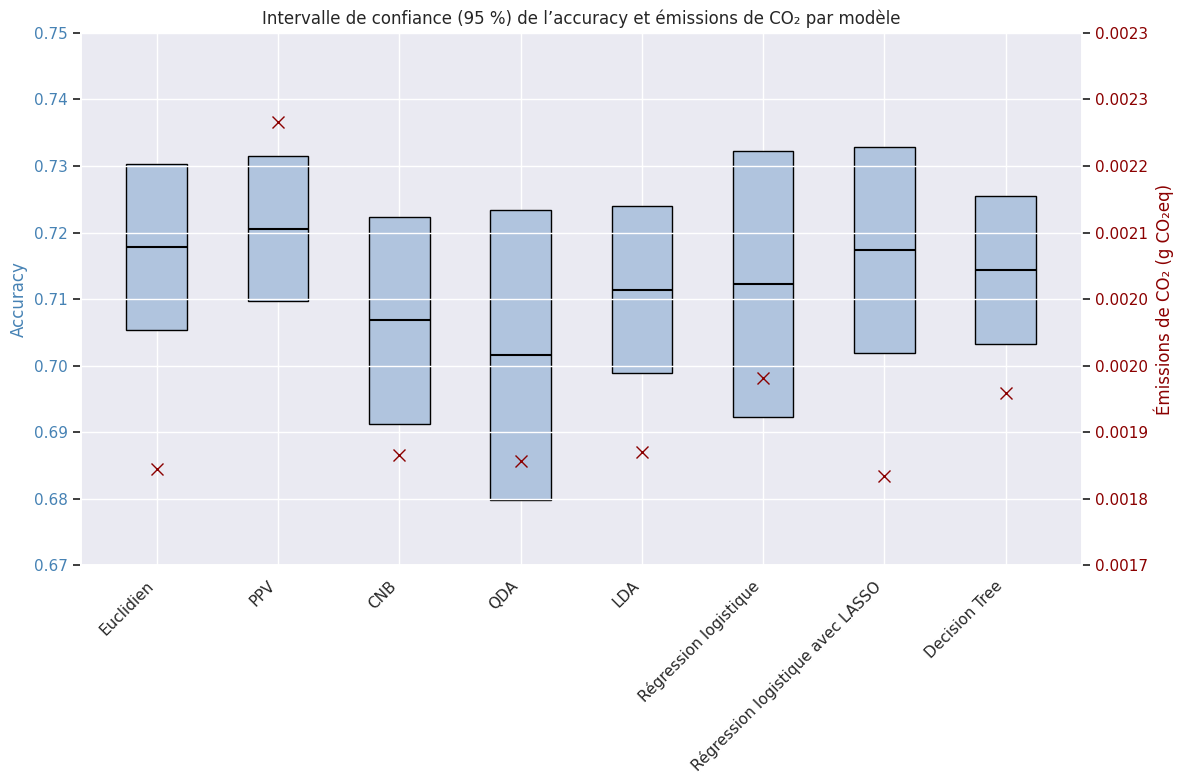

In [ ]:
# Intervalle de confiance (95 %) + émissions de CO₂
# Ce graphique combine :
#  - l’accuracy de test avec son intervalle de confiance à 95 %
#  - les émissions de CO₂ associées à chaque modèle
# Les deux axes Y partagent la même grille pour faciliter la comparaison visuelle.

# Accuracy de test par fold et par modèle (dimension : nbFolds × nb_models)
acc_folds = stock_acc_Val        # on s’assure qu’il s’agit bien des accuracies de TEST

# Moyenne de l’accuracy de test pour chaque modèle (valeurs dans [0, 1])
Acc_moy_test_ci = np.mean(acc_folds, axis=0)

# Écart-type sans biais (ddof=1) de l’accuracy sur les folds
std_acc = np.std(acc_folds, axis=0, ddof=1)

# Calcul de l’intervalle de confiance à 95 %
# IC = 1.96 * (écart-type / sqrt(nombre de folds))
ic95 = 1.96 * std_acc / np.sqrt(nbFolds)

# Définition des barres d’erreur :
# bottom = borne inférieure (moyenne - IC)
# height = hauteur totale de l’intervalle (2 × IC)
bottom = Acc_moy_test_ci - ic95
height = 2 * ic95

# Indices des modèles pour l’axe des x
x = np.arange(quant_models)

# Noms des modèles affichés sur l’axe des x
labels_models = [
    "Euclidien",
    "PPV",
    "CNB",
    "QDA",
    "LDA",
    "Régression logistique",
    "Régression logistique avec LASSO",
    "Decision Tree"
]

# Création de la figure et de l’axe principal (accuracy)
fig, ax1 = plt.subplots(figsize=(12, 8))

# Barres représentant l’intervalle de confiance à 95 %
ax1.bar(
    x,
    height,
    bottom=bottom,
    color="lightsteelblue",
    edgecolor="black",
    width=0.5
)

# --- Ligne horizontale noire représentant la moyenne de l’accuracy ---
for i in range(quant_models):
    ax1.hlines(
        Acc_moy_test_ci[i],
        i - 0.25,
        i + 0.25,
        colors="black",
        linewidth=1.5
    )

# Mise en forme de l’axe principal (accuracy)
ax1.set_xticks(x)
ax1.set_xticklabels(labels_models, rotation=45, ha="right")

ax1.set_ylim(0.67, 0.75)                 # limites de l’axe accuracy
ax1.set_ylabel("Accuracy", color="steelblue")
ax1.tick_params(axis='y', labelcolor="steelblue")

ax1.set_title(
    "Intervalle de confiance (95 %) de l’accuracy et émissions de CO₂ par modèle"
)

# Grille horizontale (associée uniquement à l’axe accuracy)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax1.set_axisbelow(True)

#  Second axe Y : émissions de CO₂
ax2 = ax1.twinx()  # création d’un axe Y secondaire partageant le même axe X

# Tracé des émissions de CO₂ moyennes par modèle
ax2.plot(
    x,
    emissions_models_mean,
    color="darkred",
    marker="x",
    markersize=8,
    linestyle="None"
)

ax2.set_ylabel("Émissions de CO₂ (g CO₂eq)", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

#  Synchronisation des ticks des deux axes Y
# 1) Récupération des ticks de l’axe accuracy (qui définissent la grille)
yticks_acc = ax1.get_yticks()

# 2) Définition des bornes de l’axe des émissions
emin = emissions_models_mean.min()
emax = emissions_models_mean.max()
margin = 0.0001  # petite marge visuelle pour éviter les effets de bord

ax2.set_ylim(emin - margin, emax + margin)

# 3) Transformation linéaire pour aligner les ticks des émissions
#    avec ceux de l’accuracy (grille partagée)
acc_min, acc_max = ax1.get_ylim()
yticks_em = np.interp(
    yticks_acc,
    [acc_min, acc_max],
    [emin - margin, emax + margin]
)

# Application des nouveaux ticks sur l’axe des émissions
ax2.set_yticks(yticks_em)
ax2.set_yticklabels([f"{v:.4f}" for v in yticks_em])

# Ajustement automatique des marges
fig.tight_layout()

# Affichage du graphique
plt.show()


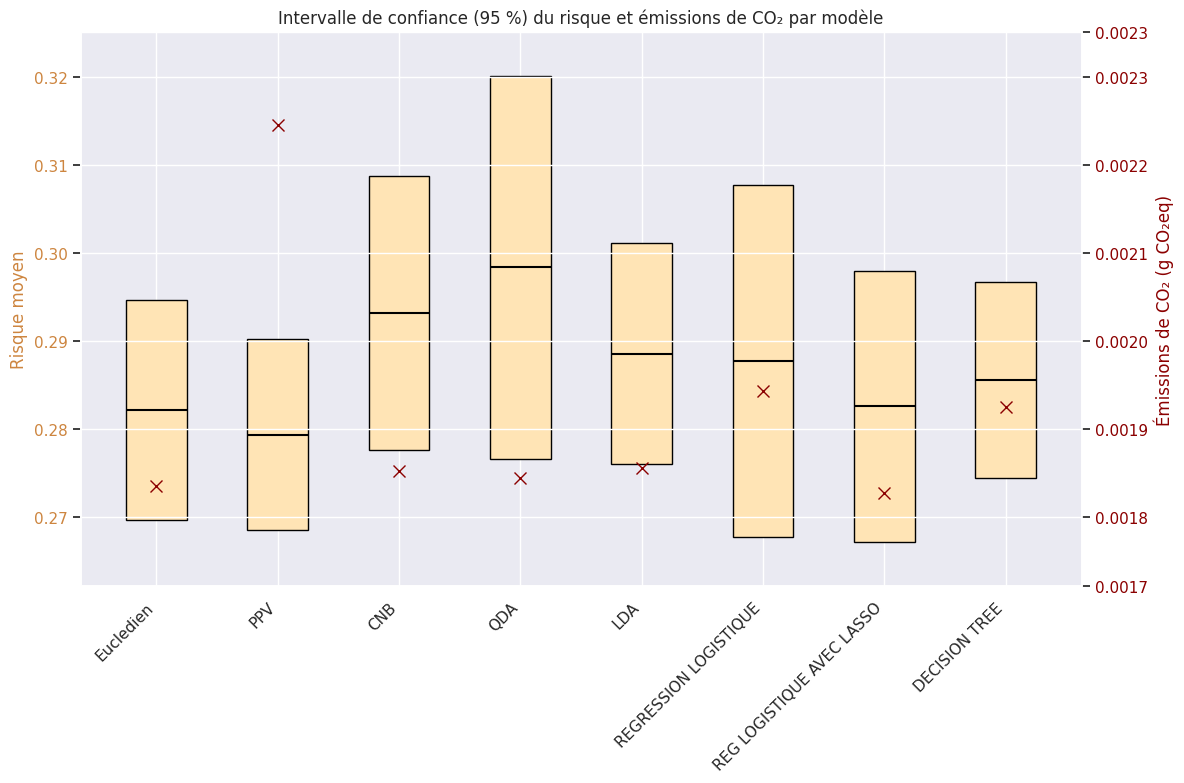

In [ ]:
# Intervalle de confiance (95 %) du RISQUE + émissions de CO₂
# Objectif :
#  - afficher le risque moyen de TEST avec son intervalle de confiance à 95 %
#  - superposer les émissions de CO₂ moyennes par modèle sur un second axe Y
#  - placer la grille EN DESSOUS des barres (zorder faible) pour améliorer la lisibilité

# Risque de test par fold et par modèle (dimension : nbFolds × nb_models)
risk_folds = stock_risk_Val  # vérifier que ce sont bien les valeurs de TEST

# Moyenne du risque de test pour chaque modèle
Risk_moy_test_ci = np.mean(risk_folds, axis=0)

# Écart-type sans biais du risque sur les folds
std_risk = np.std(risk_folds, axis=0, ddof=1)

# Intervalle de confiance à 95 % : 1.96 * (std / sqrt(nbFolds))
ic95_risk = 1.96 * std_risk / np.sqrt(nbFolds)

# Paramètres des barres (intervalle [moyenne-IC ; moyenne+IC])
bottom_risk = Risk_moy_test_ci - ic95_risk   # borne inférieure
height_risk = 2 * ic95_risk                  # hauteur totale

# Indices des modèles sur l’axe X
x = np.arange(quant_models)

# Labels à afficher sur l’axe X
labels_models = [
    "Eucledien",
    "PPV",
    "CNB",
    "QDA",
    "LDA",
    "REGRESSION LOGISTIQUE",
    "REG LOGISTIQUE AVEC LASSO",
    "DECISION TREE"
]

# Création de la figure et de l’axe principal (risque)
fig, ax1 = plt.subplots(figsize=(12, 8))

# Grille d'abord, avec un zorder faible (derrière tout le reste)
ax1.grid(axis='y', linestyle='--', alpha=0.35, zorder=0)
ax1.set_axisbelow(True)  # garantit que la grille est bien sous les éléments

# Barres de l’intervalle de confiance (au-dessus de la grille)
ax1.bar(
    x,
    height_risk,
    bottom=bottom_risk,
    color="moccasin",
    edgecolor="black",
    width=0.5,
    zorder=3  # barres au-dessus de la grille
)

# Ligne noire : moyenne du risque (encore plus au-dessus)
for i in range(quant_models):
    ax1.hlines(
        Risk_moy_test_ci[i],
        i - 0.25,
        i + 0.25,
        colors="black",
        linewidth=1.5,
        zorder=4
    )

# Mise en forme de l’axe principal (RISQUE)
ax1.set_xticks(x)
ax1.set_xticklabels(labels_models, rotation=45, ha="right")

# Définition automatique des limites de l’axe Y (risque) avec une petite marge
rmin = (bottom_risk).min()
rmax = (bottom_risk + height_risk).max()
margin_r = 0.005
ax1.set_ylim(rmin - margin_r, rmax + margin_r)

ax1.set_ylabel("Risque moyen", color="peru")
ax1.tick_params(axis='y', labelcolor="peru")
ax1.set_title("Intervalle de confiance (95 %) du risque et émissions de CO₂ par modèle")

# Second axe Y : émissions de CO₂
ax2 = ax1.twinx()  # axe secondaire partageant le même X

# Tracé des émissions (points) : affiché au-dessus de la grille
ax2.plot(
    x,
    emissions_models_mean,
    color="darkred",
    marker="x",
    markersize=8,
    linestyle="None",
    zorder=5
)

ax2.set_ylabel("Émissions de CO₂ (g CO₂eq)", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

#  Synchronisation des ticks (axe droit ↔ grille axe gauche)
# 1) On récupère les ticks de l’axe risque (ils définissent la grille)
yticks_risk = ax1.get_yticks()

# 2) On fixe les limites de l’axe des émissions (avec une marge)
emin = emissions_models_mean.min()
emax = emissions_models_mean.max()
margin_e = 0.0001
ax2.set_ylim(emin - margin_e, emax + margin_e)

# 3) On mappe linéairement les ticks du risque vers l’échelle des émissions
risk_min_ax, risk_max_ax = ax1.get_ylim()
yticks_em = np.interp(
    yticks_risk,
    [risk_min_ax, risk_max_ax],
    [emin - margin_e, emax + margin_e]
)

# Application des ticks sur l’axe des émissions (avec formatage)
ax2.set_yticks(yticks_em)
ax2.set_yticklabels([f"{v:.4f}" for v in yticks_em])

# Ajuste la mise en page pour éviter que les labels se chevauchent
fig.tight_layout()

# Affichage final
plt.show()


/tmp/ipython-input-1294861210.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1294861210.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_models, rotation=45, ha="right")
/tmp/ipython-input-1294861210.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


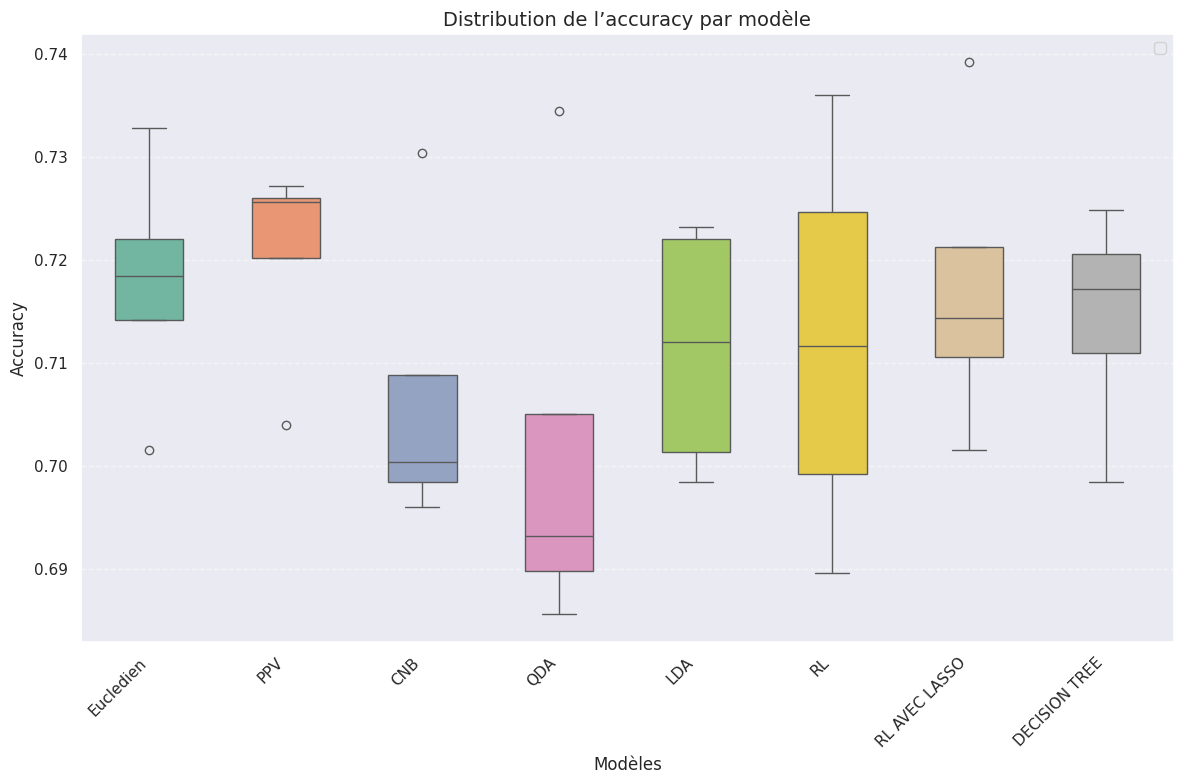

In [ ]:
# Liste des noms de modèles (dans le même ordre que les colonnes de stock_acc_Val)
labels_models = [
    "Eucledien",
    "PPV",
    "CNB",
    "QDA",
    "LDA",
    "RL",
    "RL AVEC LASSO",
    "DECISION TREE"
]

#  Passage du format "matrice" au format "long"
# stock_acc_Val est une matrice de taille (nbFolds × quant_models) :
#  - chaque ligne = un fold de validation
#  - chaque colonne = un modèle
# Pour faire un boxplot avec seaborn, on convertit ces données en DataFrame "long"
# (une ligne = une observation : {modèle, accuracy}).

rows = []
for j in range(quant_models):        # boucle sur les modèles (colonnes)
    for f in range(nbFolds):         # boucle sur les folds (lignes)
        rows.append({
            "Modèle": labels_models[j],      # nom du modèle correspondant à la colonne j
            "Accuracy": stock_acc_Val[f, j]  # accuracy du fold f pour le modèle j
        })

# Création du DataFrame final au format long
df_cv = pd.DataFrame(rows)

# Boxplot de l’accuracy par modèle
fig, ax = plt.subplots(figsize=(12, 8))  # création de la figure

sns.boxplot(
    data=df_cv,         # données au format long
    x="Modèle",         # axe X : catégories (modèles)
    y="Accuracy",       # axe Y : variable numérique (accuracy)
    ax=ax,
    width=0.5           # largeur des boîtes
)

#  Mise en forme (axes, titre, grille)
ax.set_xlabel("Modèles", fontsize=12)  # label axe X
ax.set_ylabel("Accuracy", fontsize=12) # label axe Y

# Rotation des labels pour éviter le chevauchement
ax.set_xticklabels(labels_models, rotation=45, ha="right")

ax.set_title("Distribution de l’accuracy par modèle", fontsize=14)  # titre du graphique

# Ajout d’une grille horizontale pour faciliter la lecture
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

# Remarque : un boxplot seaborn n’ajoute pas de légende automatiquement (pas de variable 'hue')
# ax.legend() est donc inutile ici (et peut afficher une légende vide selon les versions).
ax.legend()

plt.tight_layout()  # ajuste automatiquement les marges
plt.show()          # affiche le graphique


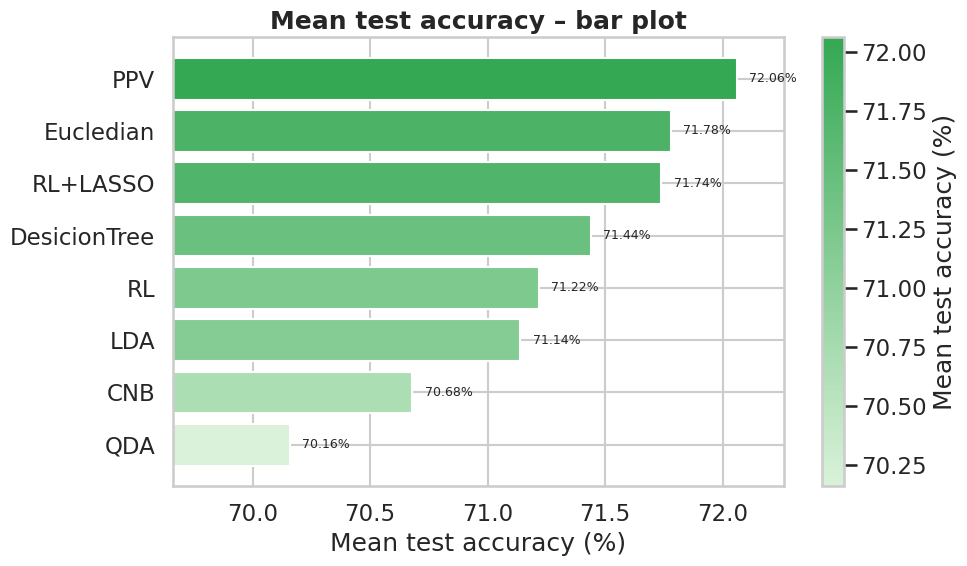

In [ ]:
#  BARRES ORDONNÉES PAR MEAN TEST ACCURACY (DÉGRADÉ DE VERT)
# Objectif :
#  - tracer un barplot horizontal des accuracies moyennes de TEST (en %)
#  - trier les modèles du meilleur au moins bon
#  - utiliser uniquement une palette de verts (clair = moins bon, foncé = meilleur)
#  - afficher les valeurs sur les barres + une colorbar associée


sns.set_theme(style="whitegrid", context="talk", font_scale=1.0)

#  Extraction des données
# Accuracy moyenne de TEST en pourcentage
acc_mean = emissions_df['test_accuracy'].values * 100

# Noms des modèles (colonne "model" du DataFrame)
models = emissions_df['model'].values

#  Tri par performance (descendant)
# np.argsort donne les indices triés ; [::-1] inverse pour avoir le meilleur en premier
sorted_idx = np.argsort(acc_mean)[::-1]
acc_sorted = acc_mean[sorted_idx]
models_sorted = models[sorted_idx]

#  Création d'étiquettes "propres"
# On enlève le préfixe "model" et on renomme certains modèles pour les abréger
pretty_map = {
    'RegressionLogistic': 'RL',
    'RegressionLogisticLASSO': 'RL+LASSO',
}

labels_sorted = []
for m in models_sorted:
    # supprime "model" uniquement au début si présent
    base = m.replace('model', '', 1) if m.startswith('model') else m
    # remplace éventuellement par une version plus lisible (RL, RL+LASSO, etc.)
    label = pretty_map.get(base, base)
    labels_sorted.append(label)

#  Couleurs : dégradé de vert
# On normalise les valeurs d'accuracy pour les mapper dans une colormap
from matplotlib.colors import Normalize
norm = Normalize(vmin=acc_sorted.min(), vmax=acc_sorted.max())

# Colormap personnalisée : vert très clair -> vert foncé
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    "green_gradient",
    ["#d9f2d9", "#34a853"]  # vert très clair -> vert plus foncé
)

# Couleur de chaque barre (fonction de l'accuracy)
colors = cmap(norm(acc_sorted))

#  Tracé du barplot horizontal
fig, ax = plt.subplots(figsize=(10, 6))

# Barres horizontales : labels à gauche, accuracy en x
bars = ax.barh(labels_sorted, acc_sorted, color=colors)

# Inverse l'axe Y pour avoir le meilleur modèle en haut
ax.invert_yaxis()

#  Zoom sur l'axe X
# On resserre l'échelle pour mieux voir les différences (au lieu de commencer à 0)
xmin = acc_sorted.min() - 0.5
xmax = acc_sorted.max() + 0.2
ax.set_xlim(xmin, xmax)

#  Titres et axes
ax.set_xlabel('Mean test accuracy (%)')
ax.set_title('Mean test accuracy – bar plot', fontweight='bold')

#  Annotation : valeur au bout de chaque barre
offset = 0.02 * (xmax - xmin)  # petit décalage pour que le texte ne touche pas la barre

for bar, val in zip(bars, acc_sorted):
    ax.text(
        bar.get_width() + offset,                # position x (fin de barre + offset)
        bar.get_y() + bar.get_height() / 2,      # position y (centre de la barre)
        f"{val:.2f}%",                           # texte formaté
        va='center',
        fontsize=9
    )

#  Colorbar (légende du dégradé)
# ScalarMappable permet de créer une colorbar cohérente avec cmap + norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # nécessaire pour éviter certains warnings

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean test accuracy (%)')

# Ajustement final de la mise en page et affichage
plt.tight_layout()
plt.show()


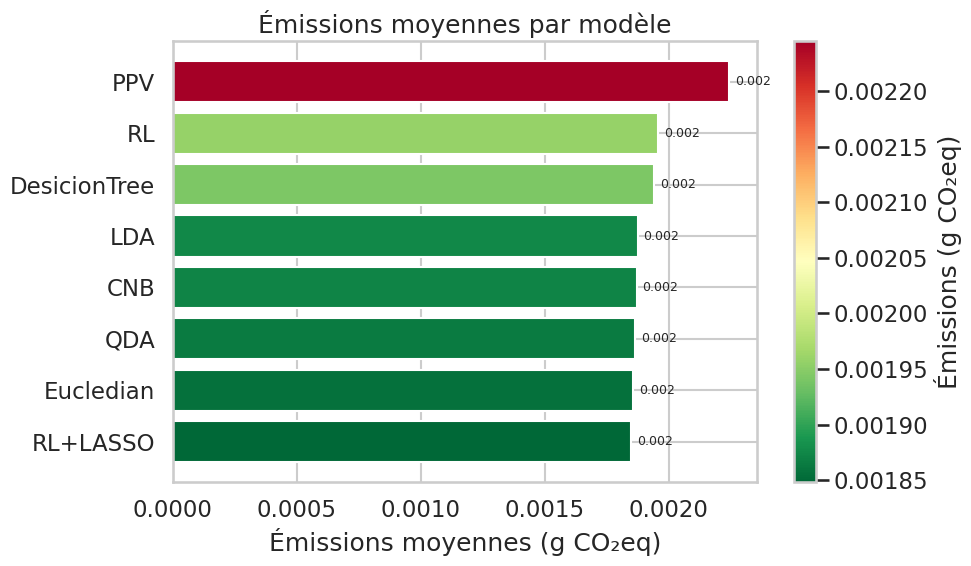

In [ ]:
#  GRAPHIQUE : ÉMISSIONS MOYENNES PAR MODÈLE
# Objectif :
#  - visualiser les émissions moyennes (g CO₂eq) de chaque modèle
#  - trier les modèles du plus émetteur au moins émetteur
#  - utiliser un dégradé de couleurs (rouge = plus émetteur, vert = moins émetteur)
#  - annoter chaque barre avec la valeur numérique + afficher une colorbar

#  Données
# Extraction des émissions moyennes (en g CO₂eq) et des noms des modèles depuis emissions_df
emissions = emissions_df['emissions_g'].values   # émissions moyennes par modèle
models    = emissions_df['model'].values         # noms internes des modèles

#  Tri (du plus émetteur au moins émetteur)
# np.argsort trie en ordre croissant ; [::-1] inverse pour obtenir un tri décroissant
sorted_idx       = np.argsort(emissions)[::-1]
emissions_sorted = emissions[sorted_idx]
models_sorted    = models[sorted_idx]

#  Noms plus lisibles (optionnel)
# On supprime le préfixe "model" et on remplace certains noms par des abréviations
pretty_map = {
    'RegressionLogistic': 'RL',
    'RegressionLogisticLASSO': 'RL+LASSO',
}

labels_sorted = []
for m in models_sorted:
    # retire "model" uniquement si c’est le début du nom
    base = m.replace('model', '', 1) if m.startswith('model') else m
    # remplace par une version plus courte si elle existe dans le dictionnaire
    label = pretty_map.get(base, base)
    labels_sorted.append(label)

#  Couleurs : rouge → jaune → vert
# Normalisation des émissions pour les mapper à la colormap
from matplotlib.colors import Normalize
norm = Normalize(vmin=emissions_sorted.min(), vmax=emissions_sorted.max())

# RdYlGn_r : version inversée (max -> rouge, min -> vert)
cmap = plt.cm.RdYlGn_r
colors = cmap(norm(emissions_sorted))  # couleur de chaque barre selon son niveau d'émission

#  Tracé du barplot horizontal
fig, ax = plt.subplots(figsize=(10, 6))

# Barres horizontales : labels à gauche, émissions en x
bars = ax.barh(labels_sorted, emissions_sorted, color=colors)

# Titres et étiquettes
ax.set_xlabel('Émissions moyennes (g CO₂eq)')
ax.set_title('Émissions moyennes par modèle')

# Inverse l’axe Y pour afficher le modèle le plus polluant en haut
ax.invert_yaxis()

#  Annotation des valeurs
# Décalage pour placer le texte juste après la barre
offset = 0.01 * emissions_sorted.max()

for bar, val in zip(bars, emissions_sorted):
    ax.text(
        bar.get_width() + offset,                # position x
        bar.get_y() + bar.get_height() / 2,      # position y (centre de la barre)
        f"{val:.3f}",                            # valeur formatée à 3 décimales
        va='center',
        fontsize=9
    )

#  Colorbar (échelle des couleurs)
# ScalarMappable relie la colormap + la normalisation pour construire la colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # évite certains warnings

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Émissions (g CO₂eq)')

# Ajuste la mise en page et affiche
plt.tight_layout()
plt.show()


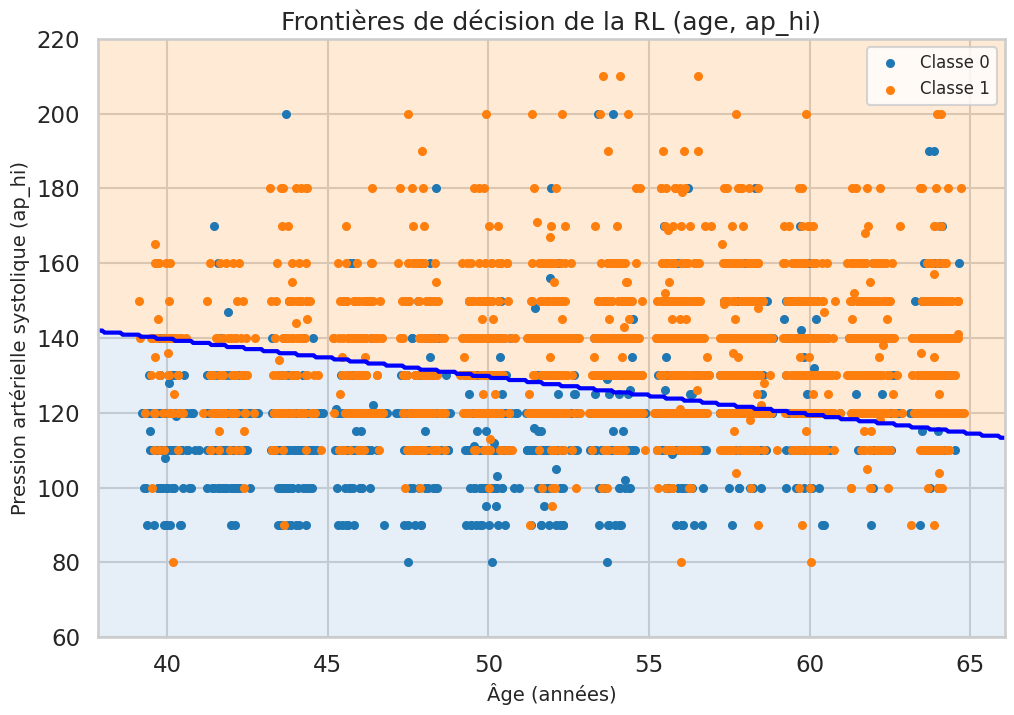

In [ ]:
# FRONTIÈRES DE DÉCISION DE LA RÉGRESSION LOGISTIQUE
# DANS LE PLAN (age, ap_hi) EN UTILISANT modelRegressionLogistic

from matplotlib.colors import ListedColormap

# 1) Dataset 2D : on ne garde que 'age' et 'ap_hi'
X_LR2D = data_train[['age', 'ap_hi']].copy()
Y_LR2D = data_train['cardio'].copy()

# 2) Construction de la grille (meshgrid) dans le plan (age, ap_hi)
age_min, age_max   = X_LR2D['age'].min(),   X_LR2D['age'].max()
aphi_min, aphi_max = X_LR2D['ap_hi'].min(), X_LR2D['ap_hi'].max()

# Marge
pad_age  = 0.05 * (age_max  - age_min)
pad_aphi = 0.05 * (aphi_max - aphi_min)

age_min  -= pad_age
age_max  += pad_age
aphi_min -= pad_aphi
aphi_max += pad_aphi

nn = 400
xx1, xx2 = np.meshgrid(
    np.linspace(age_min,  age_max,  nn),
    np.linspace(aphi_min, aphi_max, nn)
)

# DataFrame grille
grid_df = pd.DataFrame({
    'age':   xx1.ravel(),
    'ap_hi': xx2.ravel()
})

# 3) Entraînement RL + prédiction sur la grille
YhatTrain_LR2D, YhatGrid_LR2D = modelRegressionLogistic(X_LR2D, Y_LR2D, grid_df)
Z = np.array(YhatGrid_LR2D).reshape(xx1.shape)

# Colormap de fond: classe 0 = bleu clair, classe 1 = orange clair
cmap_bg = ListedColormap(["#aec7e8", "#ffbb78"])

# 4) Tracé
fig, ax = plt.subplots(figsize=(10, 7))

# Quitar márgenes blancos de la figura
fig.patch.set_alpha(0.0)                # fondo transparente
ax.set_facecolor("none")                # sin fondo extra
fig.subplots_adjust(left=0.02, right=0.98, top=0.96, bottom=0.08)

# Fond par classe prédite
cont = ax.contourf(
    xx1, xx2, Z,
    levels=[-0.5, 0.5, 1.5],
    alpha=0.3,
    cmap=cmap_bg
)

# Frontière de décision
ax.contour(
    xx1, xx2, Z,
    levels=[0.5],
    colors="blue",
    linewidths=3.0
)

# Points d'entraînement
mask0 = (Y_LR2D == 0)
mask1 = (Y_LR2D == 1)

ax.scatter(
    X_LR2D.loc[mask0, 'age'],
    X_LR2D.loc[mask0, 'ap_hi'],
    color='tab:blue',
    marker='o',
    label='Classe 0',
    s=25
)

ax.scatter(
    X_LR2D.loc[mask1, 'age'],
    X_LR2D.loc[mask1, 'ap_hi'],
    color='tab:orange',
    marker='o',
    label='Classe 1',
    s=25
)

ax.set_xlabel("Âge (années)", fontsize=14)
ax.set_ylabel("Pression artérielle systolique (ap_hi)", fontsize=14)
ax.set_title("Frontières de décision de la RL (age, ap_hi)", fontsize=18)
ax.legend(fontsize=12, loc='upper right')

# Eje Y desde 60 hacia arriba
ax.set_ylim(60, aphi_max)

plt.tight_layout(pad=0.1)
plt.show()


# Finalement, NOS INTERPRÉTATIONS ET CONCLUSION

En analysant les graphiques d’accuracy et d’émissions de carbone, nous avons pu choisir l’algorithme le plus adapté à notre base de données : Euclidean. Notre choix s’est appuyé sur deux paramètres principaux : d’une part, la précision, afin de réaliser le meilleur diagnostic possible, et d’autre part, les émissions de carbone, dans le but de contribuer à la préservation de la planète.

Nous avons observé que l’algorithme PPV 🥈 est celui qui atteint la meilleure accuracy. Cependant, nous nous sommes demandé s’il était pertinent de privilégier uniquement la précision maximale dans un contexte de diagnostic en santé lorsque cela implique des émissions plus élevées et, par conséquent, un impact indirect négatif sur l’environnement et sur nous-mêmes.

C’est pourquoi l’algorithme Euclidean 🥇nous a semblé être l’option la plus rationnelle, car il permet de trouver un équilibre entre performance prédictive et empreinte carbone.

Le troisième modèle que nous avons retenu est le Decision Tree 🥉: il offre une accuracy moyenne respectable et ses émissions sont plus faibles que celles de PPV, ce qui en fait un bon candidat lorsqu’on cherche un compromis entre précision et impact carbone. De plus, lors de la construction de l’arbre de décision, nous avons pris en compte le maintien de l’accuracy en fonction du coût computationnel. C’est pourquoi certaines variables ont été écartées, ce qui peut influencer la décision finale. Dans cette optique, envisager une valeur d’alpha différente (selon le critère/la pénalisation utilisée) pourrait encore améliorer l’accuracy, même si cela implique un coût computationnel plus élevé et, par conséquent, davantage d’émissions de carbone, si l’on souhaite privilégier une sécurité accrue — un aspect particulièrement important en milieu médical.



Par ailleurs, utiliser un arbre avec moins de feuilles nous a permit de limiter le risque de surapprentissage (overfitting).

À propos du surapprentissage, nous n’en avons pas observé dans nos algorithmes. Nous l’avons vérifié grâce à la validation croisée, en obtenant des valeurs d’accuracy similaires entre les ensembles d’entraînement et de test.

Cela dit, cette décision est prise en considérant que l’algorithme ne serait pas utilisé dans des cas déterminants pour la santé d’une personne. Dans des situations critiques ou à haut risque, nous n’hésiterions pas à privilégier le modèle le plus fiable (c’est-à-dire celui avec la meilleure accuracy), même si cela entraîne un impact environnemental plus important ; dans ce cas, nous choisirions PPV.

Après avoir présenté notre top 3, nous poursuivons avec notre avis sur les autres méthodes, qui ont également obtenu de bons résultats.

Dans le cas de la LDA et de la QDA, nous avons dû supprimer les variables catégorielles, ce qui nous a fait perdre une partie de l’information disponible dans la base de données. Par conséquent, ces modèles ont été entraînés sur une représentation incomplète des données et leurs performances peuvent ne pas refléter pleinement le potentiel prédictif du jeu de données original. Pour cette raison, nous considérons que les résultats obtenus avec la LDA et la QDA ne nous apportent pas le même niveau de confiance que d’autres méthodes ayant pu exploiter l’ensemble des variables pertinentes.

Si l’on prend en compte l’interprétabilité, dans notre cas particulier — où nous analysons une problématique médicale — l’algorithme de régression logistique s’avère particulièrement intéressant. Associé à LASSO, il permet d’effectuer une sélection automatique de variables, en supprimant celles qui sont les moins pertinentes. Cela réduit non seulement la complexité computationnelle du modèle, mais améliore aussi son interprétabilité, en facilitant l’identification des variables qui influencent le plus significativement la classification. Comme travail futur, il serait pertinent d’approfondir l’analyse des coefficients du modèle (valeurs de β), afin d’interpréter quantitativement l’influence de chaque variable sur la prédiction. Nous avons fait un exemple de la frontière de desicion selon deux variables (qui sont les plus importantes selon l'arbre de decision) : âge et pression systolique.

En termes d’interprétabilité, PPV et Euclidean sont tous deux très faibles. Étant des méthodes basées sur les distances et les voisins, elles ne produisent pas de paramètres explicites (comme des coefficients ou des règles) permettant d’expliquer directement quelles variables influencent la prédiction et dans quelle mesure. Cependant, nous maintenons que, dans un contexte médical, nous considérons qu'il faut privilégier une accuracy plus élevée, puisque l’objectif principal est de maximiser la fiabilité du diagnostic.





# L'intelligence artificielle

On ne peut pas ignorer l’utilité de l’intelligence artificielle aujourd’hui. Dans ce travail, nous l’avons utilisée pour traduire nos commentaires de l’espagnol (notre langue maternelle) vers le français, pour améliorer la qualité de nos graphiques et ainsi assurer une meilleure cohérence visuelle pour les lecteurs, et enfin pour nous aider à comprendre et corriger des erreurs difficiles à interpréter.



In [ ]:
!jupyter nbconvert --to html PROJET_G21.ipynb

[NbConvertApp] Converting notebook PROJET_G21.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 24 image(s).
[NbConvertApp] Writing 2984768 bytes to PROJET_G21.html
